In [57]:
# autoreload
%reload_ext autoreload
%autoreload 2

# Initial processing and visulisation of calcification data

Currently only using my spreadsheet. Initial look at data and methods to fit calcification rates wrt some independent variable.

Some notes, upon reviewing the [PNAS paper](https://www.pnas.org/doi/full/10.1073/pnas.2015265118):

1. Climate models
    - Higher-resolution (0.25º rather than 1º) from CMIP6
    - Factor in ensemble uncertainty rather than simply taking mean
2. Non-linear relationships: a number of papers show a parabolic relationship? This could show increase then decrease in net calcification over time/space
3. Meta summary statistics
    - Total number of studies, total number of datapoints
    - Number of responses per intervention
    - Proportion of locations (by number of surveys, by number of samples)
    - Don’t have reef type consistently between studies, but this *is* a subset of studies. This could be an interesting comparison, but may be getting too complex
    - Quantify different types of studies e.g. ocean acidification and X calcification, N interactive effects etc.
4. Plot decline in NCP as a function of time (if using several timesteps): year in which it switches from production to erosion (perhaps by ocean basin)
5. Reef accretion rates relative to sea level rise
    - PNAS uses mean sea level rise (which alone is pretty catastrophic), but given spatial variability in sea level rise would be interesting to compare spatially to find the biggest losers.
6. What rates are we taking into account? e.g. sediment dissolution rates still assumed to match those measured on lagoon sediments? (unlikely given variability of flushing)
7. “some shallower reefs may actually benefit from rising sea levels, with increasing accommodation space allowing for increased coral vertical growth (40). Indeed, this has been observed in the past (41) during much slower rates of sea level rise. It is unknown whether these possible gains in accretion will outweigh losses due to ocean warming and acidification, but determining when and where this could occur should be an urgent focus for future research” – outside scope of this paper, but interesting!
8. QA questions:
    - “we do not include Halimeda spp. in our model because of the unclear nature of its eventual contribution to reef accretion and because of the larger uncertainty regarding the impacts of ocean acidification and warming on its calcification that was observed during our surveys of the literature.” –Same this time round?
        - Measure species-wise variation in calcification? i.e. these would just be messy plots of response vs variables
    2. “Seawater carbonate chemistry was recalculated in some studies where inconsistencies were found between pH scales”
        - When to recalculate seawater chemistry?
    3. Convert from NBS to Total
        - “Studies using the National Bureau of Standards scale were converted to the total scale (hereafter "pH") using the excel macro CO2sys (51) and method following ref. 52” – I can do this better with cybsyst
    4. “Research examining the effects of ocean acidification were excluded if they did not present standardized measurements of seawater carbonate chemistry that could allow us to accurately determine pH on the total scale (53).”
    5. Extra rates
        - Did I include bioerosion?
        - Sediment production?
7. Environmental variables:
    - Pretty rule of thumb for DHW metric (can perhaps do better): “we assume that if a coral reef community suffers two or more marine heatwaves of a certain DHW extent within one decade, these events will not allow them to recover to their original coral cover.”


In [117]:
### imports
# general
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# custom
import utils

In [628]:
### load data
fp = "data/Orlando_data.xlsx"
# algae data
df = pd.read_excel(fp, sheet_name="combined")
df = df[df.Include == 'yes']    # filter out data not matching criteria
df['Year'] = pd.to_datetime(df['Year'], format='%Y')    # datetime format for later plotting
df[['DOI', 'Year', 'Authors',]] = df[['DOI', 'Year', 'Authors']].ffill()
df.columns = df.columns.str.replace(' ', '_')   # process columns to replace whitespace with underscore
df.columns = df.columns.str.replace('[()]', '', regex=True) # remove '(' and ')' from column names
# remove any rows in which 'n' has '~' in the string
df = df[~df['n'].str.contains('~', na=False)]
df.head()

Notes  Secondary_check Include  \
0   NaN                1     yes   
1   NaN                1     yes   
2   NaN                1     yes   
3   NaN                1     yes   
4   NaN                1     yes   

                                             Authors                DOI  \
0  Bergstrom E.; Lahnstein J.; Collins H.; Page T...  10.1111/jpy.13290   
1  Bergstrom E.; Lahnstein J.; Collins H.; Page T...  10.1111/jpy.13290   
2  Bergstrom E.; Lahnstein J.; Collins H.; Page T...  10.1111/jpy.13290   
3  Bergstrom E.; Lahnstein J.; Collins H.; Page T...  10.1111/jpy.13290   
4  Bergstrom E.; Lahnstein J.; Collins H.; Page T...  10.1111/jpy.13290   

        Year              Species_types   Taxa                       Location  \
0 2023-01-01     Porollithon cf onkodes  Algae  Lizard Island, GBR, Australia   
1 2023-01-01     Porollithon cf onkodes  Algae  Lizard Island, GBR, Australia   
2 2023-01-01     Porollithon cf onkodes  Algae  Lizard Island, GBR, Australia   
3 2023-01-01     Porollithon cf onkodes  Algae  Lizard Island, GBR, Australia   
4 2023-01-01  Lithophyllum cf insipidum  Algae  Lizard Island, GBR, Australia   

                                              Coords  ... Temperature_sd_ºC  \
0  14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...  ...               NaN   
1  14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...  ...               NaN   
2  14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...  ...               NaN   
3  14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...  ...               NaN   
4  14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...  ...               NaN   

   Salinity_ppt  Salinity_se_ppt  Salinity_sd_ppt  n  Calcification  \
0          35.0              0.2              NaN  5       1.970803   
1          35.0              0.2              NaN  5       2.408759   
2          35.0              0.2              NaN  5       1.664234   
3          35.1              0.2              NaN  5       1.839416   
4          35.0              0.2              NaN  5       1.467626   

   Calcification_se  Calcification_sd  Calcification_units  Unnamed:_57  
0          0.255550               NaN         mg cm-2day-1          NaN  
1          0.189760               NaN         mg cm-2day-1          NaN  
2          0.167864               NaN         mg cm-2day-1          NaN  
3          0.124074               NaN         mg cm-2day-1          NaN  
4          0.131372               NaN         mg cm-2day-1          NaN  

[5 rows x 58 columns]

In [633]:
# assign value for each row to coords, or if no coords, location
df['loc'] = df['Coords'].fillna(df['Location'])
df['loc'].unique()

array(['14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 145°27′02.9″ E',
       '17°28′40.51″S, 149°50′22.80″W', '25.02° N, 80.49° W',
       "Mo'orea, French Polynesia", '26°19.62’N, 80°04.33’W',
       'Palmyra Atoll', '18° 33.001’ S,\n146° 29.304’ E',
       '17.05°N 111.3°S\n111.28°–111.32°E', 'Fiji, UK aquarium', 'M',
       '23°26′S 151°52′E', 'Fiji', 'Island Point, Panama',
       'Gulf of Aqaba, Jordan', '18°12′N, 109°28′E',
       'Almirante Bay, Panama', '23 33’S, 151 54’E',
       'Ikei Island, Okinawa, Japan', '26° 38′N, 127°51′E',
       '18° 41.126′S, 146° 30.731′E', 'Hawaii, various',
       '21.955°E, 120.766°N / 21.931°E, 120,745°N',
       'Oku Reef, Okinawa, Japan', '16°24′43.2″ N 119°54′12.2″ E',
       '23°27′34″S 151°55′45″E',
       '18°12′7′′N, 109°28′5′′E / 18°16′40′′N, 109°44′3′′E',
       '18.15°N, 109.30°E', 'Spermonde Archipelago, Sulawesi, Indonesia',
       '21°26′6″ N, 157°47′12″ W', '20°54′19.80″N, 86°50′6.20″W',
       '7°19′13.2″N, 134°30′00.6″E', '17°48

In [637]:
coords_array = df['Coords'].dropna().unique()
coords_array

array(['14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 145°27′02.9″ E',
       '17°28′40.51″S, 149°50′22.80″W', '25.02° N, 80.49° W',
       '26°19.62’N, 80°04.33’W', '18° 33.001’ S,\n146° 29.304’ E',
       '17.05°N 111.3°S\n111.28°–111.32°E', '23°26′S 151°52′E',
       '18°12′N, 109°28′E', '23 33’S, 151 54’E', '26° 38′N, 127°51′E',
       '18° 41.126′S, 146° 30.731′E',
       '21.955°E, 120.766°N / 21.931°E, 120,745°N',
       '16°24′43.2″ N 119°54′12.2″ E', '23°27′34″S 151°55′45″E',
       '18°12′7′′N, 109°28′5′′E / 18°16′40′′N, 109°44′3′′E',
       '18.15°N, 109.30°E', '21°26′6″ N, 157°47′12″ W',
       '20°54′19.80″N, 86°50′6.20″W', '7°19′13.2″N, 134°30′00.6″E',
       '17°48.96S, 149°81.88 W', 'N 26°42.15′, E 127°52.667’',
       '17°28′46.60″S 149°49′8.27″W', '151°550E, 23°270S',
       '21°26′08.9′′ N, 157°47′12.0′′ W', '24.56257° N, 81.40009° W',
       '18° 15′ N; 109° 25′ E', '110°65′E, 19°25′N'], dtype=object)

In [676]:
for coord in coords_array:
    try:
        lat, lon = parse_coordinates(coord)
        print(f"Original: {coord} → Decimal Degrees: ({lat}, {lon})")
    except ValueError as e:
        print(e)


Original: 14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 145°27′02.9″ E → Decimal Degrees: (-14.688166666666667, 145.46766666666667)
Original: 17°28′40.51″S, 149°50′22.80″W → Decimal Degrees: (-17.477919444444442, -149.8396666666667)
Original: 25.02° N, 80.49° W → Decimal Degrees: (25.02, -80.49)
Unknown coordinate format: 26°19.62’N, 80°04.33’W
Unknown coordinate format: 18° 33.001’ S,
146° 29.304’ E
Original: 17.05°N 111.3°S
111.28°–111.32°E → Decimal Degrees: (17.05, 111.3)
Unknown coordinate format: 23°26′S 151°52′E
Unknown coordinate format: 18°12′N, 109°28′E
Unknown coordinate format: 23 33’S, 151 54’E
Unknown coordinate format: 26° 38′N, 127°51′E
Unknown coordinate format: 18° 41.126′S, 146° 30.731′E
Unknown coordinate format: 21.955°E, 120.766°N / 21.931°E, 120,745°N
Original: 16°24′43.2″ N 119°54′12.2″ E → Decimal Degrees: (16.412, 119.9033888888889)
Original: 23°27′34″S 151°55′45″E → Decimal Degrees: (-23.459444444444443, 151.92916666666665)
Unknown coordinate format: 18°12′7′′

In [675]:
import re

def dms_to_dd(degrees, minutes=0, seconds=0, direction=""):
    """Convert degrees, minutes, and seconds to decimal degrees."""
    decimal_degrees = float(degrees) + float(minutes) / 60 + float(seconds) / 3600
    if direction in ["S", "W"]:
        decimal_degrees *= -1
    return decimal_degrees

def parse_coordinates(coord):
    """Convert various coordinate formats to decimal degrees."""
    coord = coord.strip()

    # **Decimal Degrees (DD)**
    # Example: "-14.6680433, 145.463777"
    dd_match = re.match(r"(-?\d+\.\d+)\s*[°]?\s*,?\s*(-?\d+\.\d+)\s*[°]?", coord)
    if dd_match:
        return float(dd_match.group(1)), float(dd_match.group(2))

    # **Degrees and Decimal Minutes (DMM)**
    # Example: "25.02° N, 80.49° W"
    dmm_match = re.match(
        r"(\d+\.?\d*)°\s*([NS]),?\s*(\d+\.?\d*)°\s*([EW])?", coord
    )
    if dmm_match:
        lat_dd = dms_to_dd(dmm_match.group(1), direction=dmm_match.group(2))
        lon_dd = dms_to_dd(dmm_match.group(3), direction=dmm_match.group(4))
        return lat_dd, lon_dd
    
    # **Degrees and Decimal Minutes (DMM), directions first**
    dmm_cfirst = re.match(
        r"([NS])\s*(\d+)°\s*([\d.]+)[′']?,?\s*([EW])\s*(\d+)°\s*([\d.]+)[′']?", coord)
    
    if dmm_cfirst:
        lat_dd = dms_to_dd(dmm_cfirst.group(2), direction=dmm_cfirst.group(3))
        lon_dd = dms_to_dd(dmm_cfirst.group(5), direction=dmm_cfirst.group(4))
        return lat_dd, lon_dd

    # 
    # **Degrees, Minutes, and Seconds (DMS)**
    # Example: "17°28′40.51″S, 149°50′22.80″W"
    dms_match = re.match(
        r"(\d+)°\s*(\d+)[′']\s*([\d.]+)[″\"]?\s*([NS]),?\s*(\d+)°\s*(\d+)[′']\s*([\d.]+)[″\"]?\s*([EW])?", coord
    )
    if dms_match:
        lat_dd = dms_to_dd(dms_match.group(1), dms_match.group(2), dms_match.group(3), dms_match.group(4))
        lon_dd = dms_to_dd(dms_match.group(5), dms_match.group(6), dms_match.group(7), dms_match.group(8))
        return lat_dd, lon_dd

    raise ValueError(f"Unknown coordinate format: {coord}")

# Example usages
coordinates = [
    "-14.6680433, 145.463777",  # Decimal degrees
    "14°40.0826'S, 145°27.8266'E",  # DMM
    "14°40'4.96\"S, 145°27'49.6\"E",  # DMS
]

for coord in coordinates:
    try:
        lat, lon = parse_coordinates(coord)
        print(f"Original: {coord} → Decimal Degrees: ({lat}, {lon})")
    except ValueError as e:
        print(e)


Original: -14.6680433, 145.463777 → Decimal Degrees: (-14.6680433, 145.463777)
Unknown coordinate format: 14°40.0826'S, 145°27.8266'E
Original: 14°40'4.96"S, 145°27'49.6"E → Decimal Degrees: (-14.668044444444444, 145.46377777777778)


In [598]:
# load in others
denisa_df = pd.read_excel("data/Data extraction_Denisa.xlsx", sheet_name="Data extraction")
ashtyn_df = pd.read_excel("data/DataExtraction_AI.xlsx", sheet_name="Data_Extraction")

# concatenate data

import googlemaps

GOOGLE_MAPS_API_KEY = utils.read_yaml("api_keys.yaml")['google_maps_api']

gmaps_client = googlemaps.Client(key=GOOGLE_MAPS_API_KEY)

locs = pd.DataFrame(denisa_df.Location.unique(), columns=["Location"])

# comment this out to avoid too many api calls
locs[["Latitude", "Longitude"]] = locs["Location"].apply(lambda x: utils.get_coordinates_from_gmaps(x, gmaps_client))


# denisa_df.Location.unique(), ashtyn_df.Location.unique()

Error for 12°7′29.07″N, 68°58′22.92″W: INVALID_REQUEST
Error for 9.34S, 82.22W: INVALID_REQUEST
Error for 24.62055° N, 81.37078° W: INVALID_REQUEST
Error for 14°37′32.1″S, 145°38′06.2″E: INVALID_REQUEST
Error for 7.268°N, 134.522°E: INVALID_REQUEST
Error for 21.4°N, 157.8°W: INVALID_REQUEST
Error for 17°32'S 149°50'W: INVALID_REQUEST
Error for 16°55′S,145°46′E: INVALID_REQUEST


In [605]:
locs

DOI  coordinates                       location
Latitude   10.1111/jpy.13290   -14.668043  Lizard Island, GBR, Australia
Longitude  10.1111/jpy.13290   145.463777  Lizard Island, GBR, Australia

In [620]:
# read locations.yaml
locs = utils.read_yaml("data/locations.yaml")

locs_df = pd.DataFrame([
    {
        "DOI": entry["DOI"],
        "Latitude": entry["coordinates"]["Latitude"],
        "Longitude": entry["coordinates"]["Longitude"],
        "Location": entry["location"]
    }
    for entry in locs
])

# drop nans
locs_df = locs_df.dropna()
# read a list of dictionaries into a single dictionary, with the keys being the location names
# locs = {k: v for d in locs for k, v in d.items()}

# save dictionary to csv
# locs = pd.DataFrame(locs)
# locs.to_csv("data/locations.csv")

In [621]:
locs_df.to_csv("data/locations.csv")

In [563]:
# read in mapping

map_dict = utils.read_yaml("data/mapping.yaml")["unit_map"]
inverted_map = {val: key for key, values in map_dict.items() for val in values}

df['Unit'] = df['Calcification_units'].map(inverted_map)
df['Unit'].value_counts()
print(df['Unit'].value_counts())
print('\nNumber of unmapped unit entries:', df['Unit'].isna().sum())

Unit
mgCaCO3 cm-2d-1       1424
μgCaCO3 cm-2d-1        428
gCaCO3 cm-2d-1         236
delta d-1              212
μmolCaCO3 g−1d−1       202
nmolCaCO3 mg-1d-1       96
µmolCaCO3 cm-2hr-1      77
µmolCaCO3 g-1hr-1       63
gCaCO3 g-1d-1           36
g d-1                   18
mg d-1                  18
µmolCaCO3 cm-2d-1       15
nmolCaCO3 cm-2hr-1      12
µg d-1                  10
gCaCO3 cm-2-1d-1         6
mgCaCO3 g-1hr-1          4
mgCaCO3 mg-1d-1          4
delta wk-1               3
Name: count, dtype: int64

Number of unmapped unit entries: 177


In [ ]:
# get list from dictionary values
unit_list = list(map_dict.values())

unit_list = [item for sublist in unit_list for item in sublist]
set(df['Calcification_units'].unique()) - set(unit_list)
# TODO: for some reason 'mgCaCO3 mg-1day-1' not mapping

{'mgCaCO3 mg-1day-1'}

In [573]:
MOLAR_MASS_CACO3 = 100.0869    # g/mol

def absolute_rate_conversion(rate_val: float, rate_unit: str):
    """Conversion into gCaCO3 m-2 day-1 for absolute rates"""
    mass_prefixes = {'m': 1e-3, 'μ': 1e-6, 'n': 1e-9}
    
    # convert moles to mass
    if 'mol' in rate_unit:
        rate_val *= MOLAR_MASS_CACO3
        mol_prefix = rate_unit.split('mol')[0]
        for prefix, factor in mass_prefixes.items():
            if prefix in mol_prefix:
                rate_val *= factor
                break
    
    # Time conversion
    time_conversions = {'hr-1': 24, 'wk-1': 1/7}
    for time_unit, factor in time_conversions.items():
        if time_unit in rate_unit:
            rate_val *= factor
            break
    
    # Area conversion
    if 'cm-2' in rate_unit.split(' ')[1]:
        rate_val *= 1e4   # cm2 to m2
    
    return rate_val
    
# apply absolute_rate_conversion and update Units column for rows which have been updated
df['Standard_calcification_rate'] = df.apply(lambda x: absolute_rate_conversion(x['Calcification'], x['Calcification_units']), axis=1)

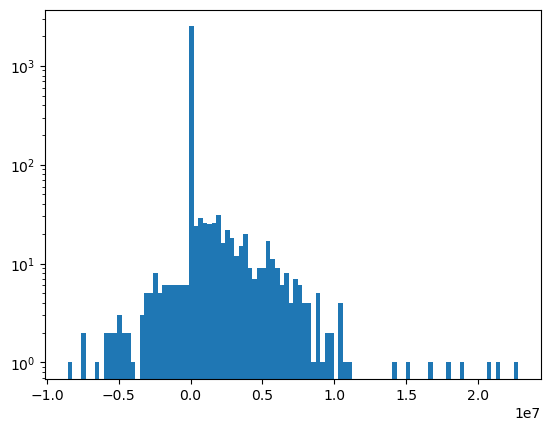

In [578]:
plt.hist(df['Standard_calcification_rate'], bins=100);
plt.yscale('log')

In [587]:
### load in 
ashtyn_df = pd.read_excel("data/DataExtraction_AI.xlsx", sheet_name="Data_Extraction")
ashtyn_df.Location.unique()

# concat with previous locations
locs = pd.DataFrame(df.Location.unique(), columns=["Location"])
all_locs = pd.concat([locs, pd.DataFrame(ashtyn_df.Location.unique(), columns=["Location"])], axis=0, ignore_index=True)
all_locs

Location
0                       Lizard Island, GBR, Australia
1                           Mo'orea, French Polynesia
2                              Key Largo, Florida, US
3                             Boca Raton, Florida, US
4                                       Palmyra Atoll
5                      Pelorus Island, GBR, Australia
6   South China Sea, 17.03°–17.07°N,\n111.28°–111....
7                                   Fiji, UK aquarium
8                                                   M
9                        Heron Island, GBR, Australia
10                                               Fiji
11                               Island Point, Panama
12                              Gulf of Aqaba, Jordan
13       Luhuitou fringing reef, Hainan Island, China
14                     Almirante Bay, Panama, in-situ
15                     Almirante Bay, Panama, ex-situ
16                                     Okinawa, Japan
17                                                NaN
18                     Fantome Island, GBR, Australia
19                                    Hawaii, various
20                                    Southern Taiwan
21                           Oku Reef, Okinawa, Japan
22                       Lucero, Bolinao, Philippines
23                               Hainan Island, China
24                                Luhuitou Bay, China
25         Spermonde Archipelago, Sulawesi, Indonesia
26                               Kāne‘ohe Bay, Hawaii
27                             Puerto Morelos, Mexico
28                                              Palau
29                                       Indo-Pacific
30              Heron Island, Southern GBR, Australia
31                               Kane'ohe Bay, Hawaii
32                                   Florida Keys, US
33               Biscayne National Park, Florida Keys
34                             Key West, Florida Keys
35                         Key Biscayne, Florida Keys
36                          Florida Bay, Florida Keys
37             Florida Keys National Marine Sanctuary
38                                   Sanya Bay, China
39                          Changjiang, Hainan, China
40                        Gulf of Aqaba-Eilat, Israel
41                                  Florida Keys, USA
42                                                NaN
43                     Xisha Islands, South China Sea
44                         Hainan Island, South China
45                                                   
46                      Lizard Island, GBR, Australia
47                                           Scotland
48                                                  M
49  Aquarium species from Oceanario de Lisboa (Por...
50                           Moorea, French Polynesia
51                                            Bermuda
52  Hobihu, Nanwan, Kenting National Park, Souther...
53                Luhuitou Reef, Hainan Island, China
54       Luhuitou fringing reef, Hainan Island, China
55                                17.53311S, 149.833N
56                                      O'ahu, Hawaii
57                        26°05′15.2″N, 126°42′25.5″E
58               Florida Reef Tract, Florida Keys, US

In [588]:
import googlemaps

GOOGLE_MAPS_API_KEY = utils.read_yaml("api_keys.yaml")['google_maps_api']

gmaps_client = googlemaps.Client(key=GOOGLE_MAPS_API_KEY)

locs = pd.DataFrame(df.Location.unique(), columns=["Location"])

# comment this out to avoid too many api calls
locs[["Latitude", "Longitude"]] = locs["Location"].apply(lambda x: utils.get_coordinates_from_gmaps(x, gmaps_client))

# # match locations with DOI
doi_locs = df[["DOI", "Location"]].drop_duplicates()
# omit 'M' and NaN
doi_locs.dropna(inplace=True)
doi_locs = doi_locs[doi_locs["Location"] != "M"]
doi_locs = doi_locs.merge(locs, left_on="Location", right_on="Location", how="left")
doi_locs.head()

DOI                       Location   Latitude  \
0           10.1111/jpy.13290  Lizard Island, GBR, Australia -14.668043   
1  10.1038/s41598-019-40620-8      Mo'orea, French Polynesia -17.538843   
2           10.3354/meps10981         Key Largo, Florida, US  25.092620   
3      10.1098/rsbl.2018.0371      Mo'orea, French Polynesia -17.538843   
4           10.3354/meps11591        Boca Raton, Florida, US  26.368306   

    Longitude  
0  145.463777  
1 -149.829523  
2  -80.442040  
3 -149.829523  
4  -80.128932

In [589]:
### write locs to yaml, with nice formatting
locs_list = []
for _, row in doi_locs.iterrows():
    locs_list.append({
        'coordinates': {
            'Latitude': row['Latitude'],
            'Longitude': row['Longitude']
        },
        'location': row['Location'],
        'DOI': row['DOI']
    })

utils.write_yaml(locs_list, "data/locations.yaml")

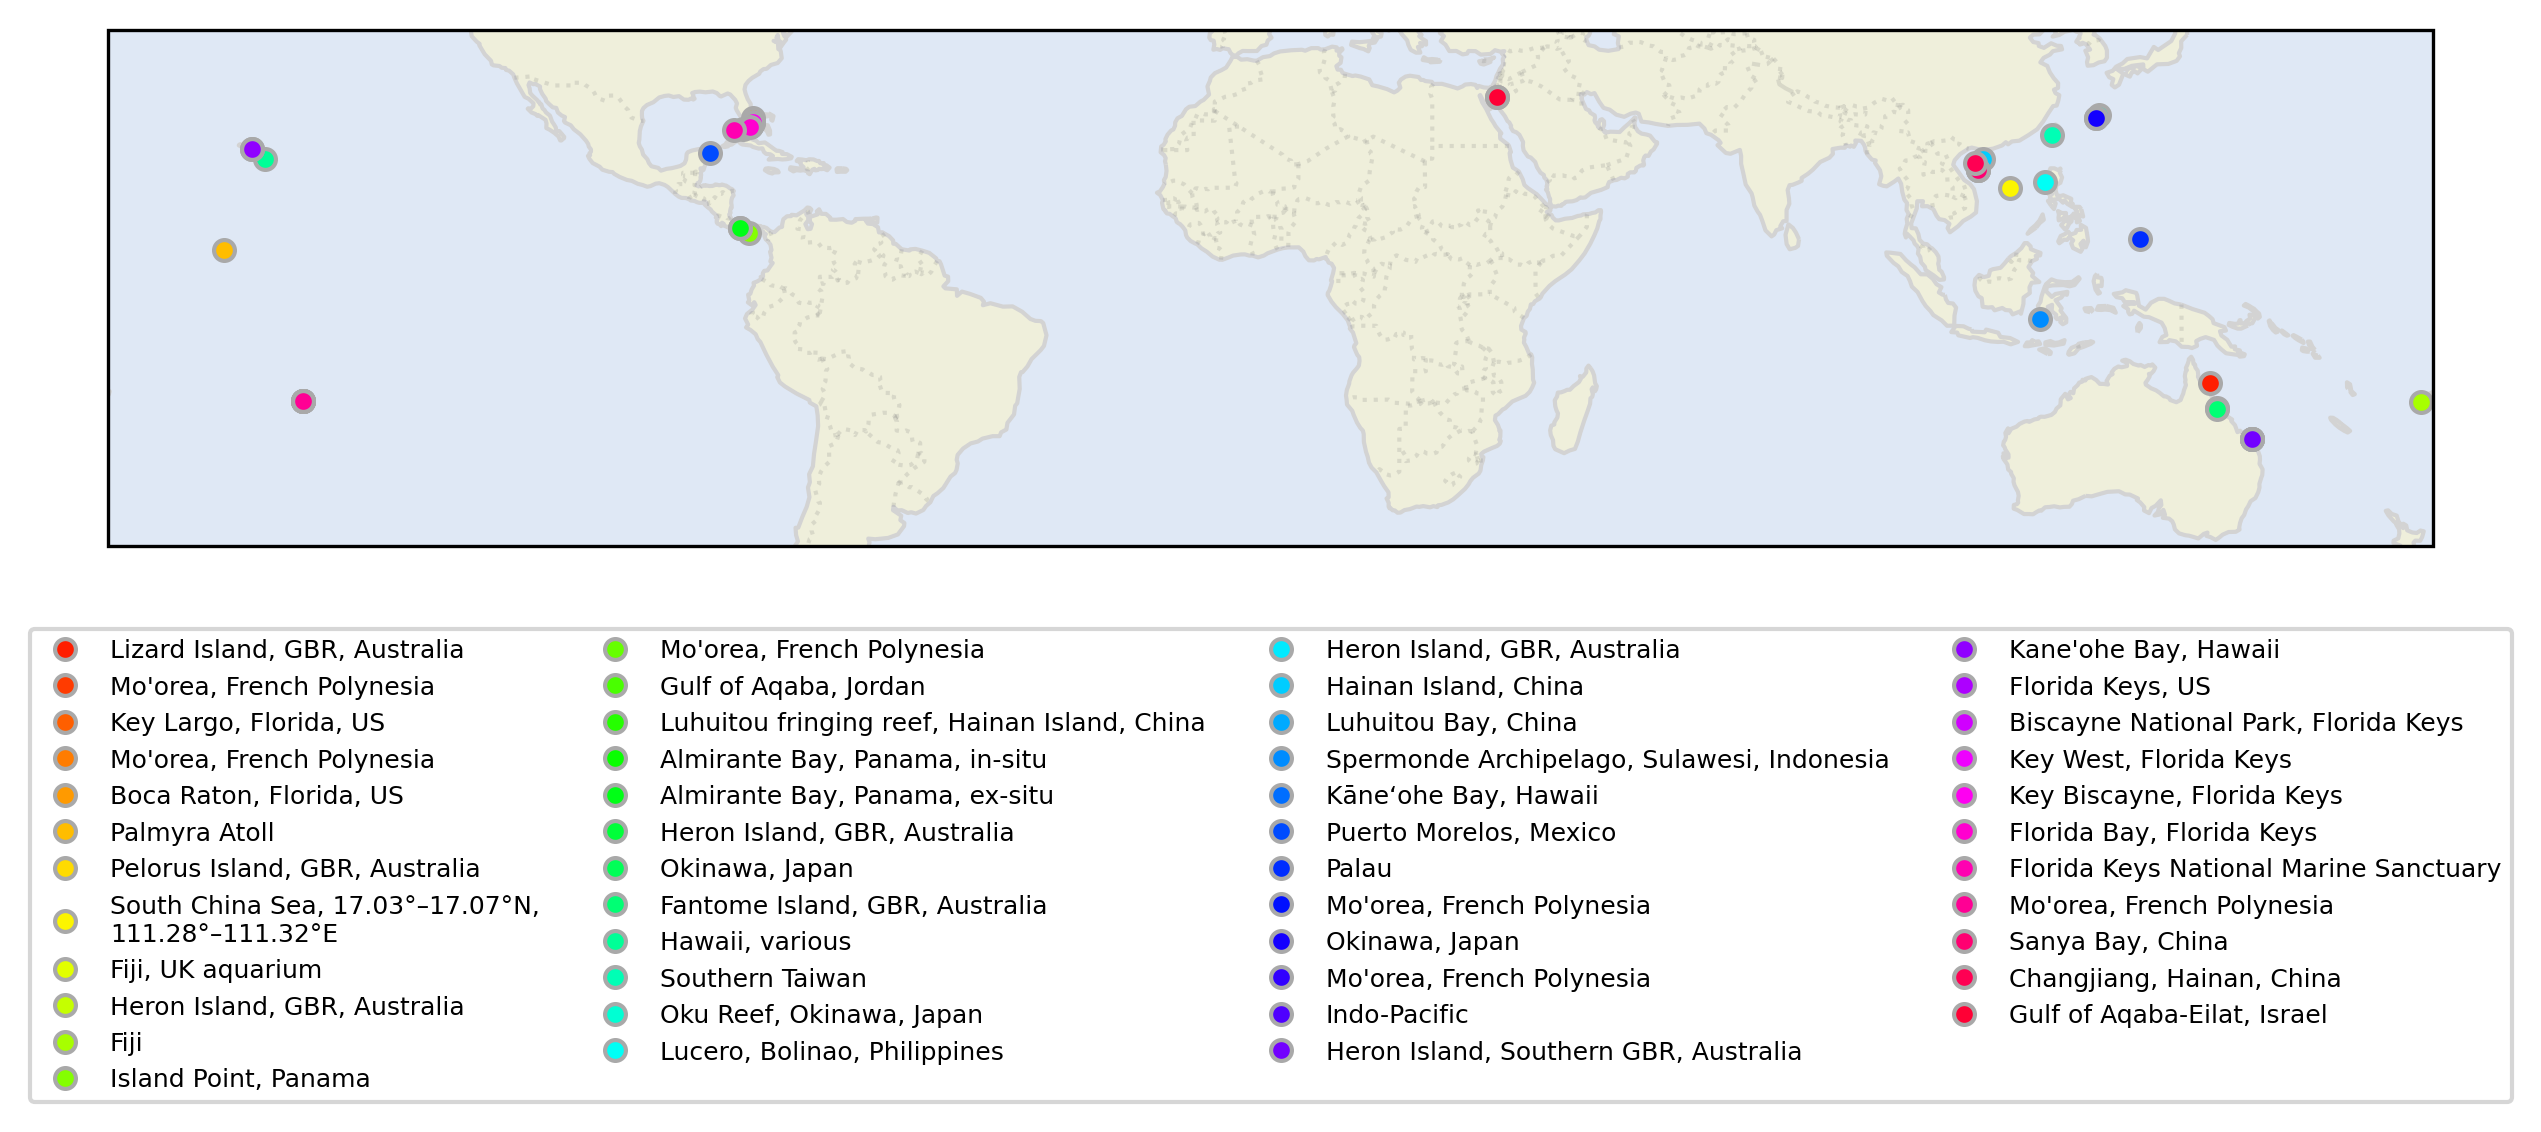

In [590]:
### plot spatial disribution of studies
locations = read_yaml("data/locations.yaml")

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locations))
for i, data in enumerate(locations):
    coords = data["coordinates"]
    ax.plot(coords["Longitude"], coords["Latitude"], 'o', markeredgecolor='darkgrey', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["location"])

# add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1), ncol=len(locations)//10, fontsize=6);

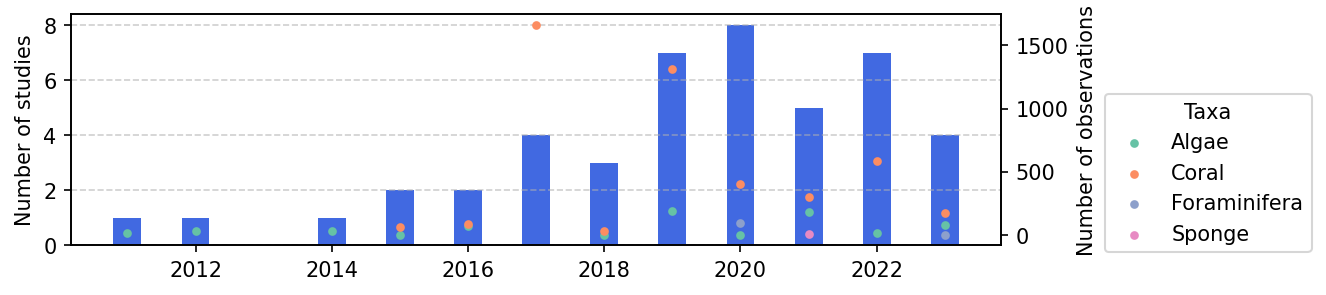

In [404]:
### plot temporal distribution of studies, breakdown by species
# create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=150)

# drop na from Year columns
dates_df = df.dropna(subset=["Year"])

# count occurrences of year of each DOI
year_counts = df.groupby('Year')['DOI'].nunique()

ax.bar(year_counts.index, year_counts.values, color='royalblue', width=150)
ax.set_ylabel("Number of studies")
ax.grid(axis='y', linestyle='--', alpha=0.6)

# group df by Taxa
taxa_df_grouped = df.groupby(['Taxa', 'Year'])

# sum total n for each unique taxa and by year
taxa_counts = taxa_df_grouped['n'].sum()

### plot number of observations each year, by 
n_ax = ax.twinx()
taxa_palette = sns.color_palette("Set2", len(unique_taxa))
taxa_color_map = dict(zip(unique_taxa, taxa_palette))
for taxa in unique_taxa:
    taxa_data = taxa_counts[taxa_counts.index.get_level_values('Taxa') == taxa]
    n_ax.scatter(taxa_data.index.get_level_values('Year'), taxa_data.values, color=taxa_color_map[taxa], alpha=1, s=10, label=taxa)

n_ax.set_ylabel("Number of observations")
n_ax.legend(title="Taxa", bbox_to_anchor=(1.1, 0.7), loc='upper left')

In [ ]:
### summary statistics
# count number of entries with pH Total values vs pH NBS
print('Number of studies:', df.DOI.nunique())
print('Number of samples:', int(df.n.sum()))
print('Number of datapoints:', df.shape[0])
print("# pH Total scale entries:", df.pH_Total.notna().sum(), "\n# pH NBS scale entries:", df.pH_NBS.notna().sum())

Number of studies: 44
Number of samples: 5269
Number of datapoints: 3029
# pH Total scale entries: 2649 
# pH NBS scale entries: 304


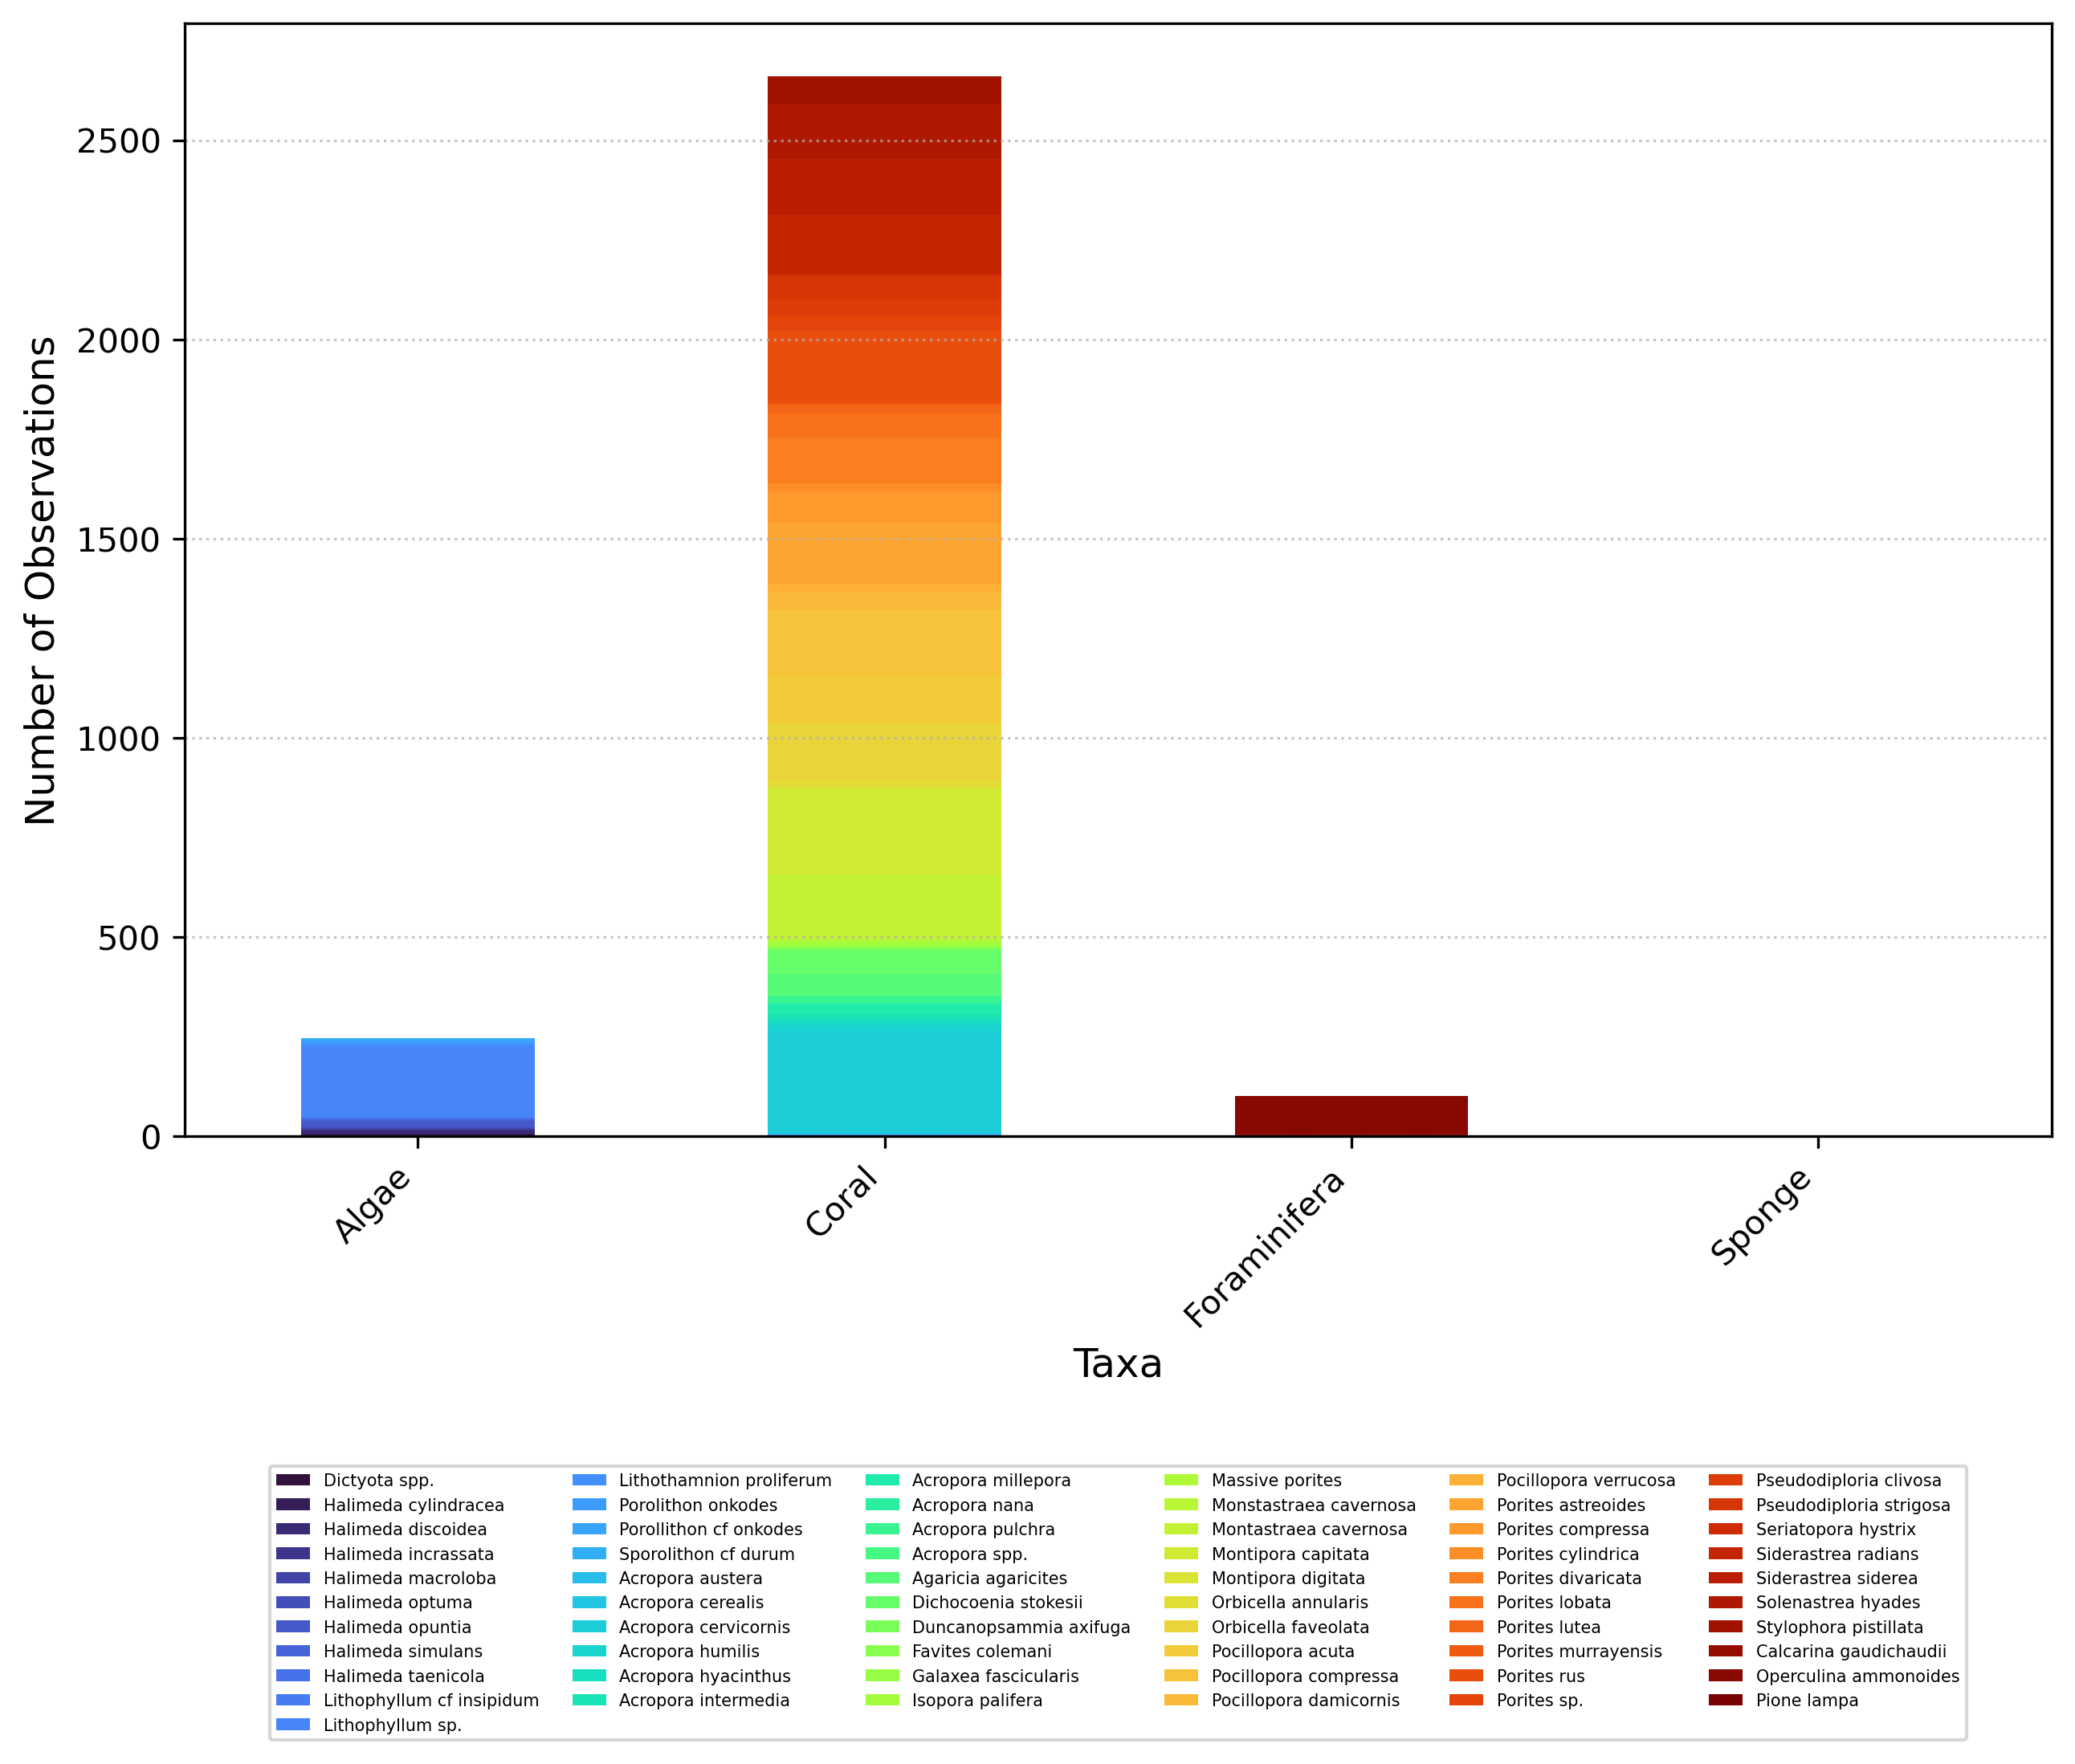

In [445]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Aggregate counts of species types within each taxa
species_counts = df.groupby(['Taxa', 'Species_types']).size().unstack(fill_value=np.nan)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
species_counts.plot(kind='bar', stacked=True, ax=ax, colormap='turbo')

# Formatting
ax.set_xlabel("Taxa", fontsize=12)
ax.set_ylabel("Number of Observations", fontsize=12)
ax.legend(fontsize=5, bbox_to_anchor=(0.5, -0.55), ncols=6, loc='lower center')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle=':', alpha=0.7)

plt.show()

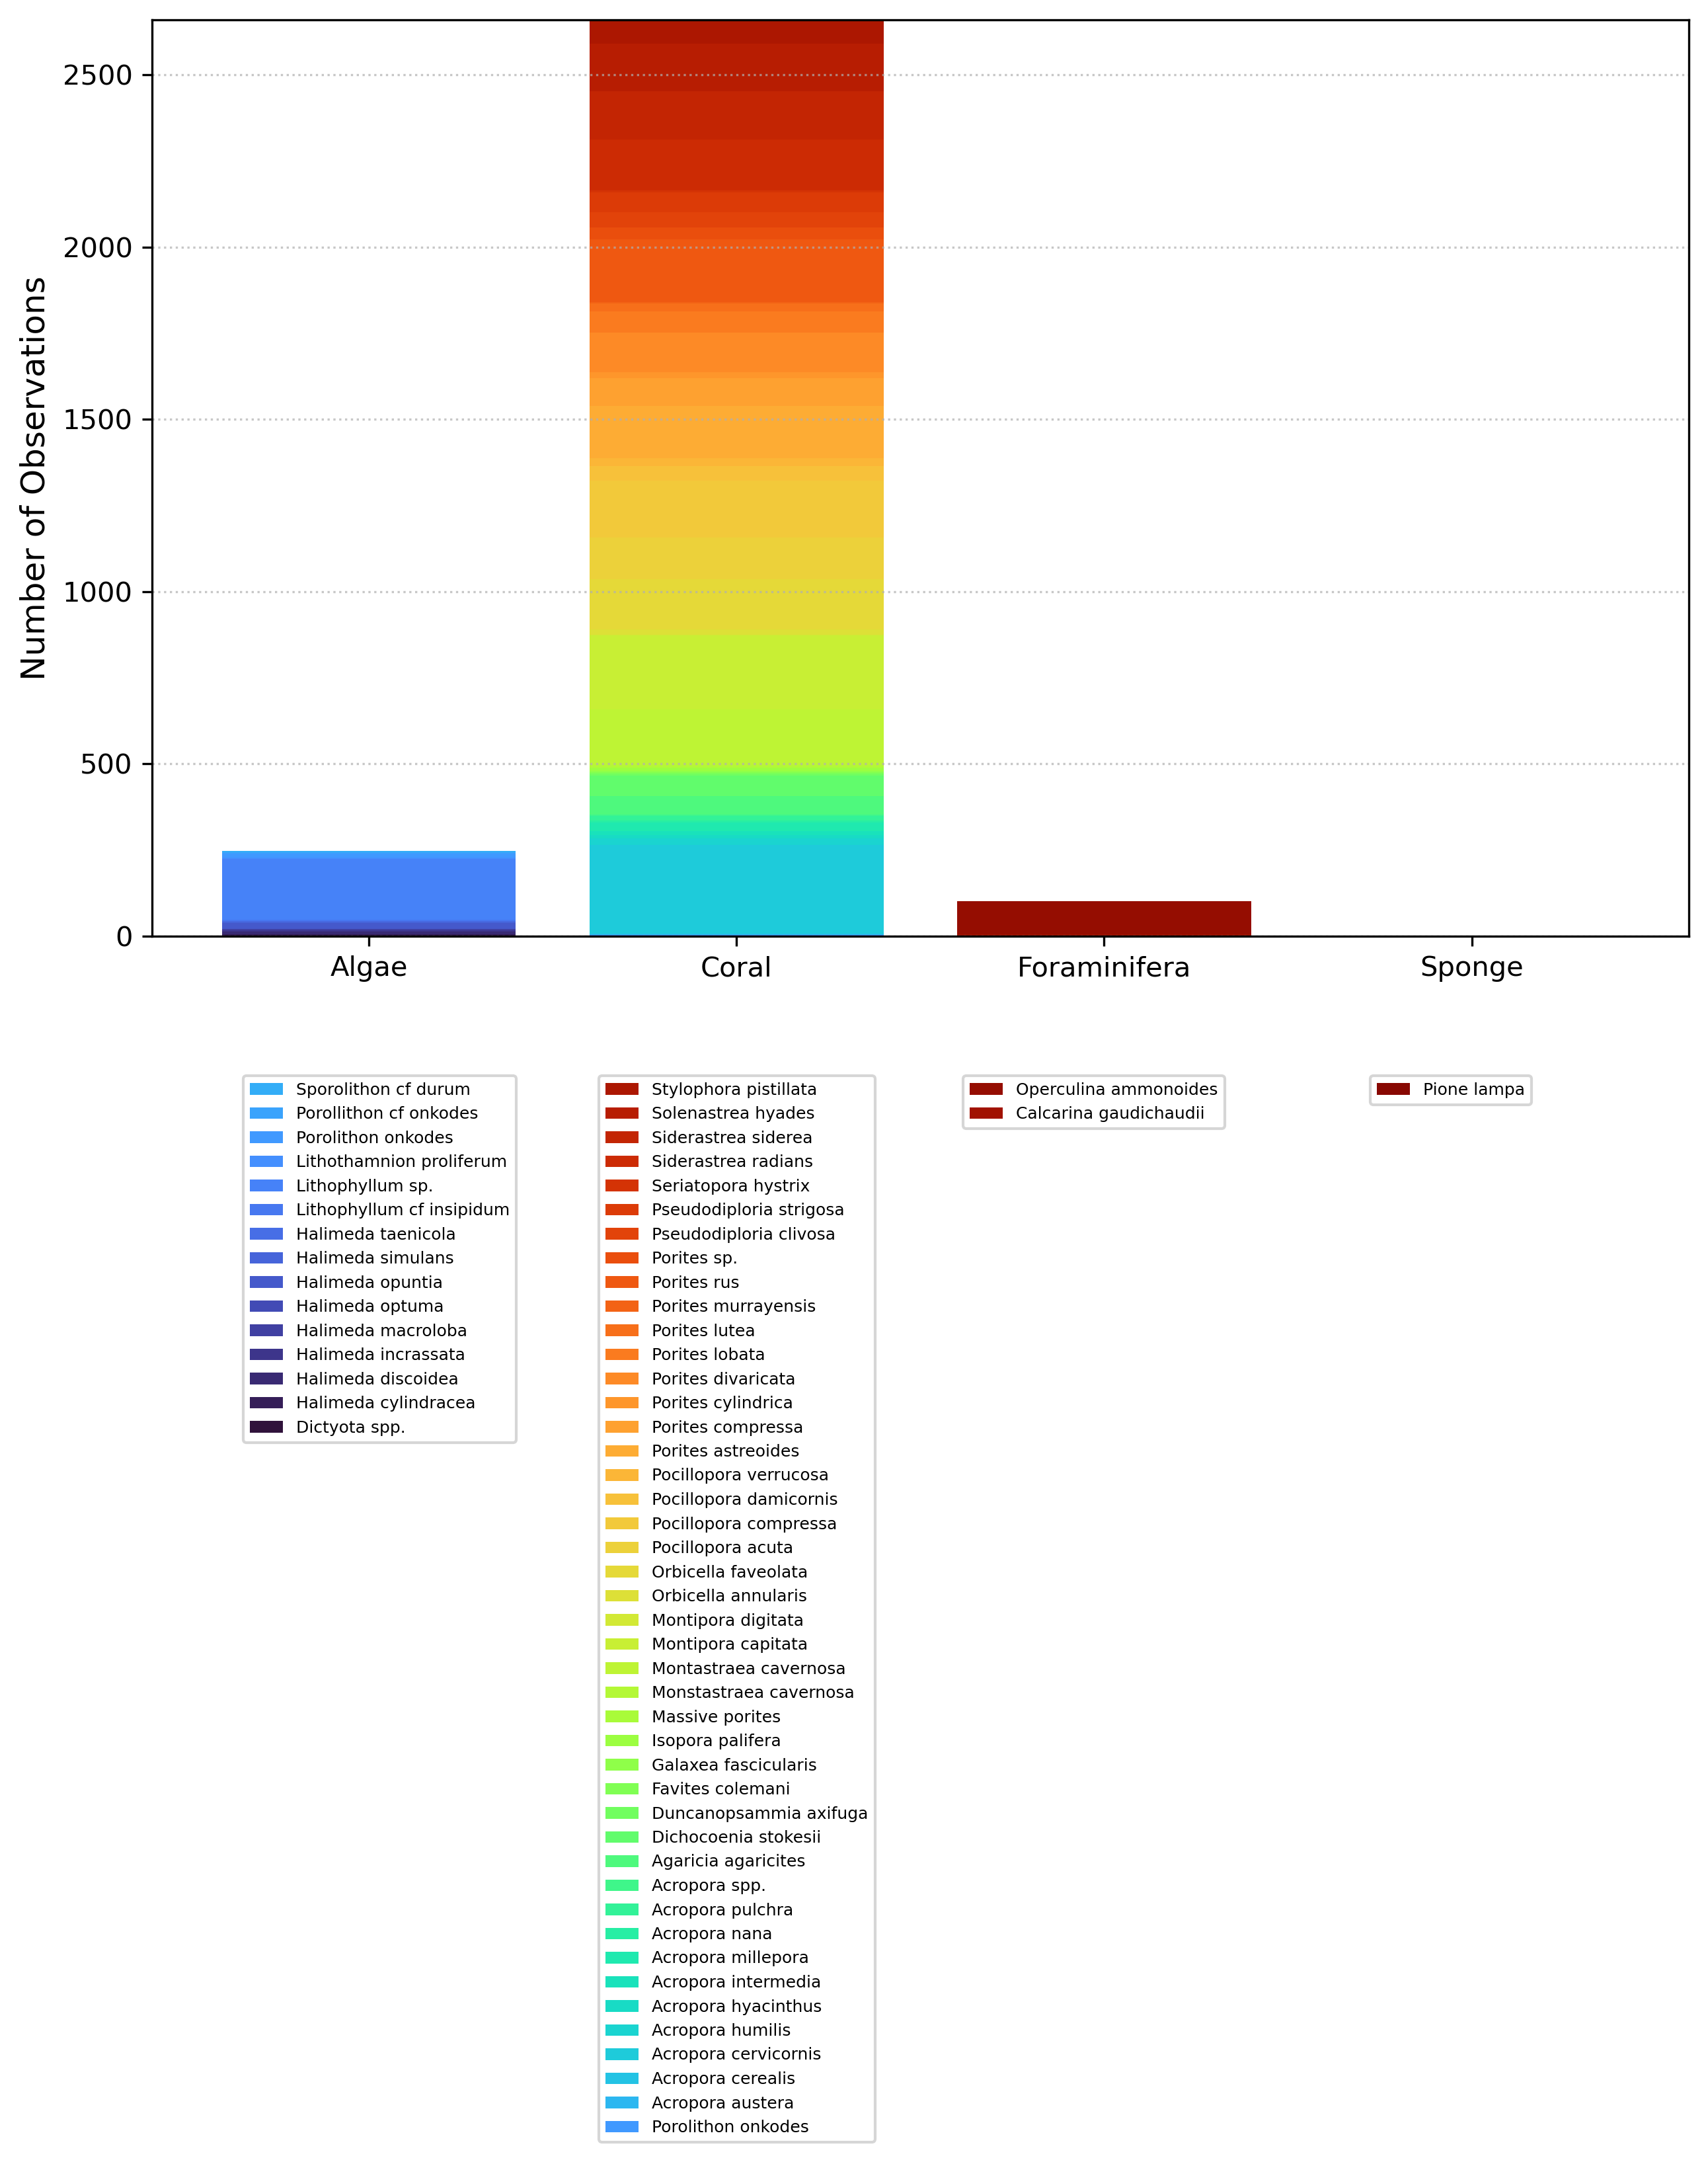

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

species_counts = df.groupby(['Taxa', 'Species_types']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

colormap = plt.get_cmap('turbo')
unique_species_types = species_counts.columns
colors = {species: colormap(i / len(unique_species_types)) for i, species in enumerate(unique_species_types)}

# Plot each taxon separately
bottom = np.zeros(len(species_counts))
legend_handles = {}

for species in unique_species_types:
    values = species_counts[species].values
    if np.any(values):  # Only plot species that have data
        bars = ax.bar(species_counts.index, values, bottom=bottom, color=colors[species], label=species)
        bottom += values

        # Store legend handles for only the species present in each taxon
        for taxon, bar, value in zip(species_counts.index, bars, values):
            if value > 0:  # Only add species that actually appear
                if taxon not in legend_handles:
                    legend_handles[taxon] = []
                legend_handles[taxon].append((bar, species))

ax.set_ylabel("Number of Observations", fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle=':', alpha=0.7)

# add separate legends for each Taxa (only relevant species types)  TODO: could put legends within plot
for i, (taxon, handles) in enumerate(legend_handles.items()):
    ax.figure.legend(
        [h[0] for h in handles[::-1]], [h[1] for h in handles[::-1]],
        # title=f"Species Types in {taxon}",
        fontsize=6, loc='upper center', bbox_to_anchor=((0.24 + i * 0.18), 0), ncol=1
    )

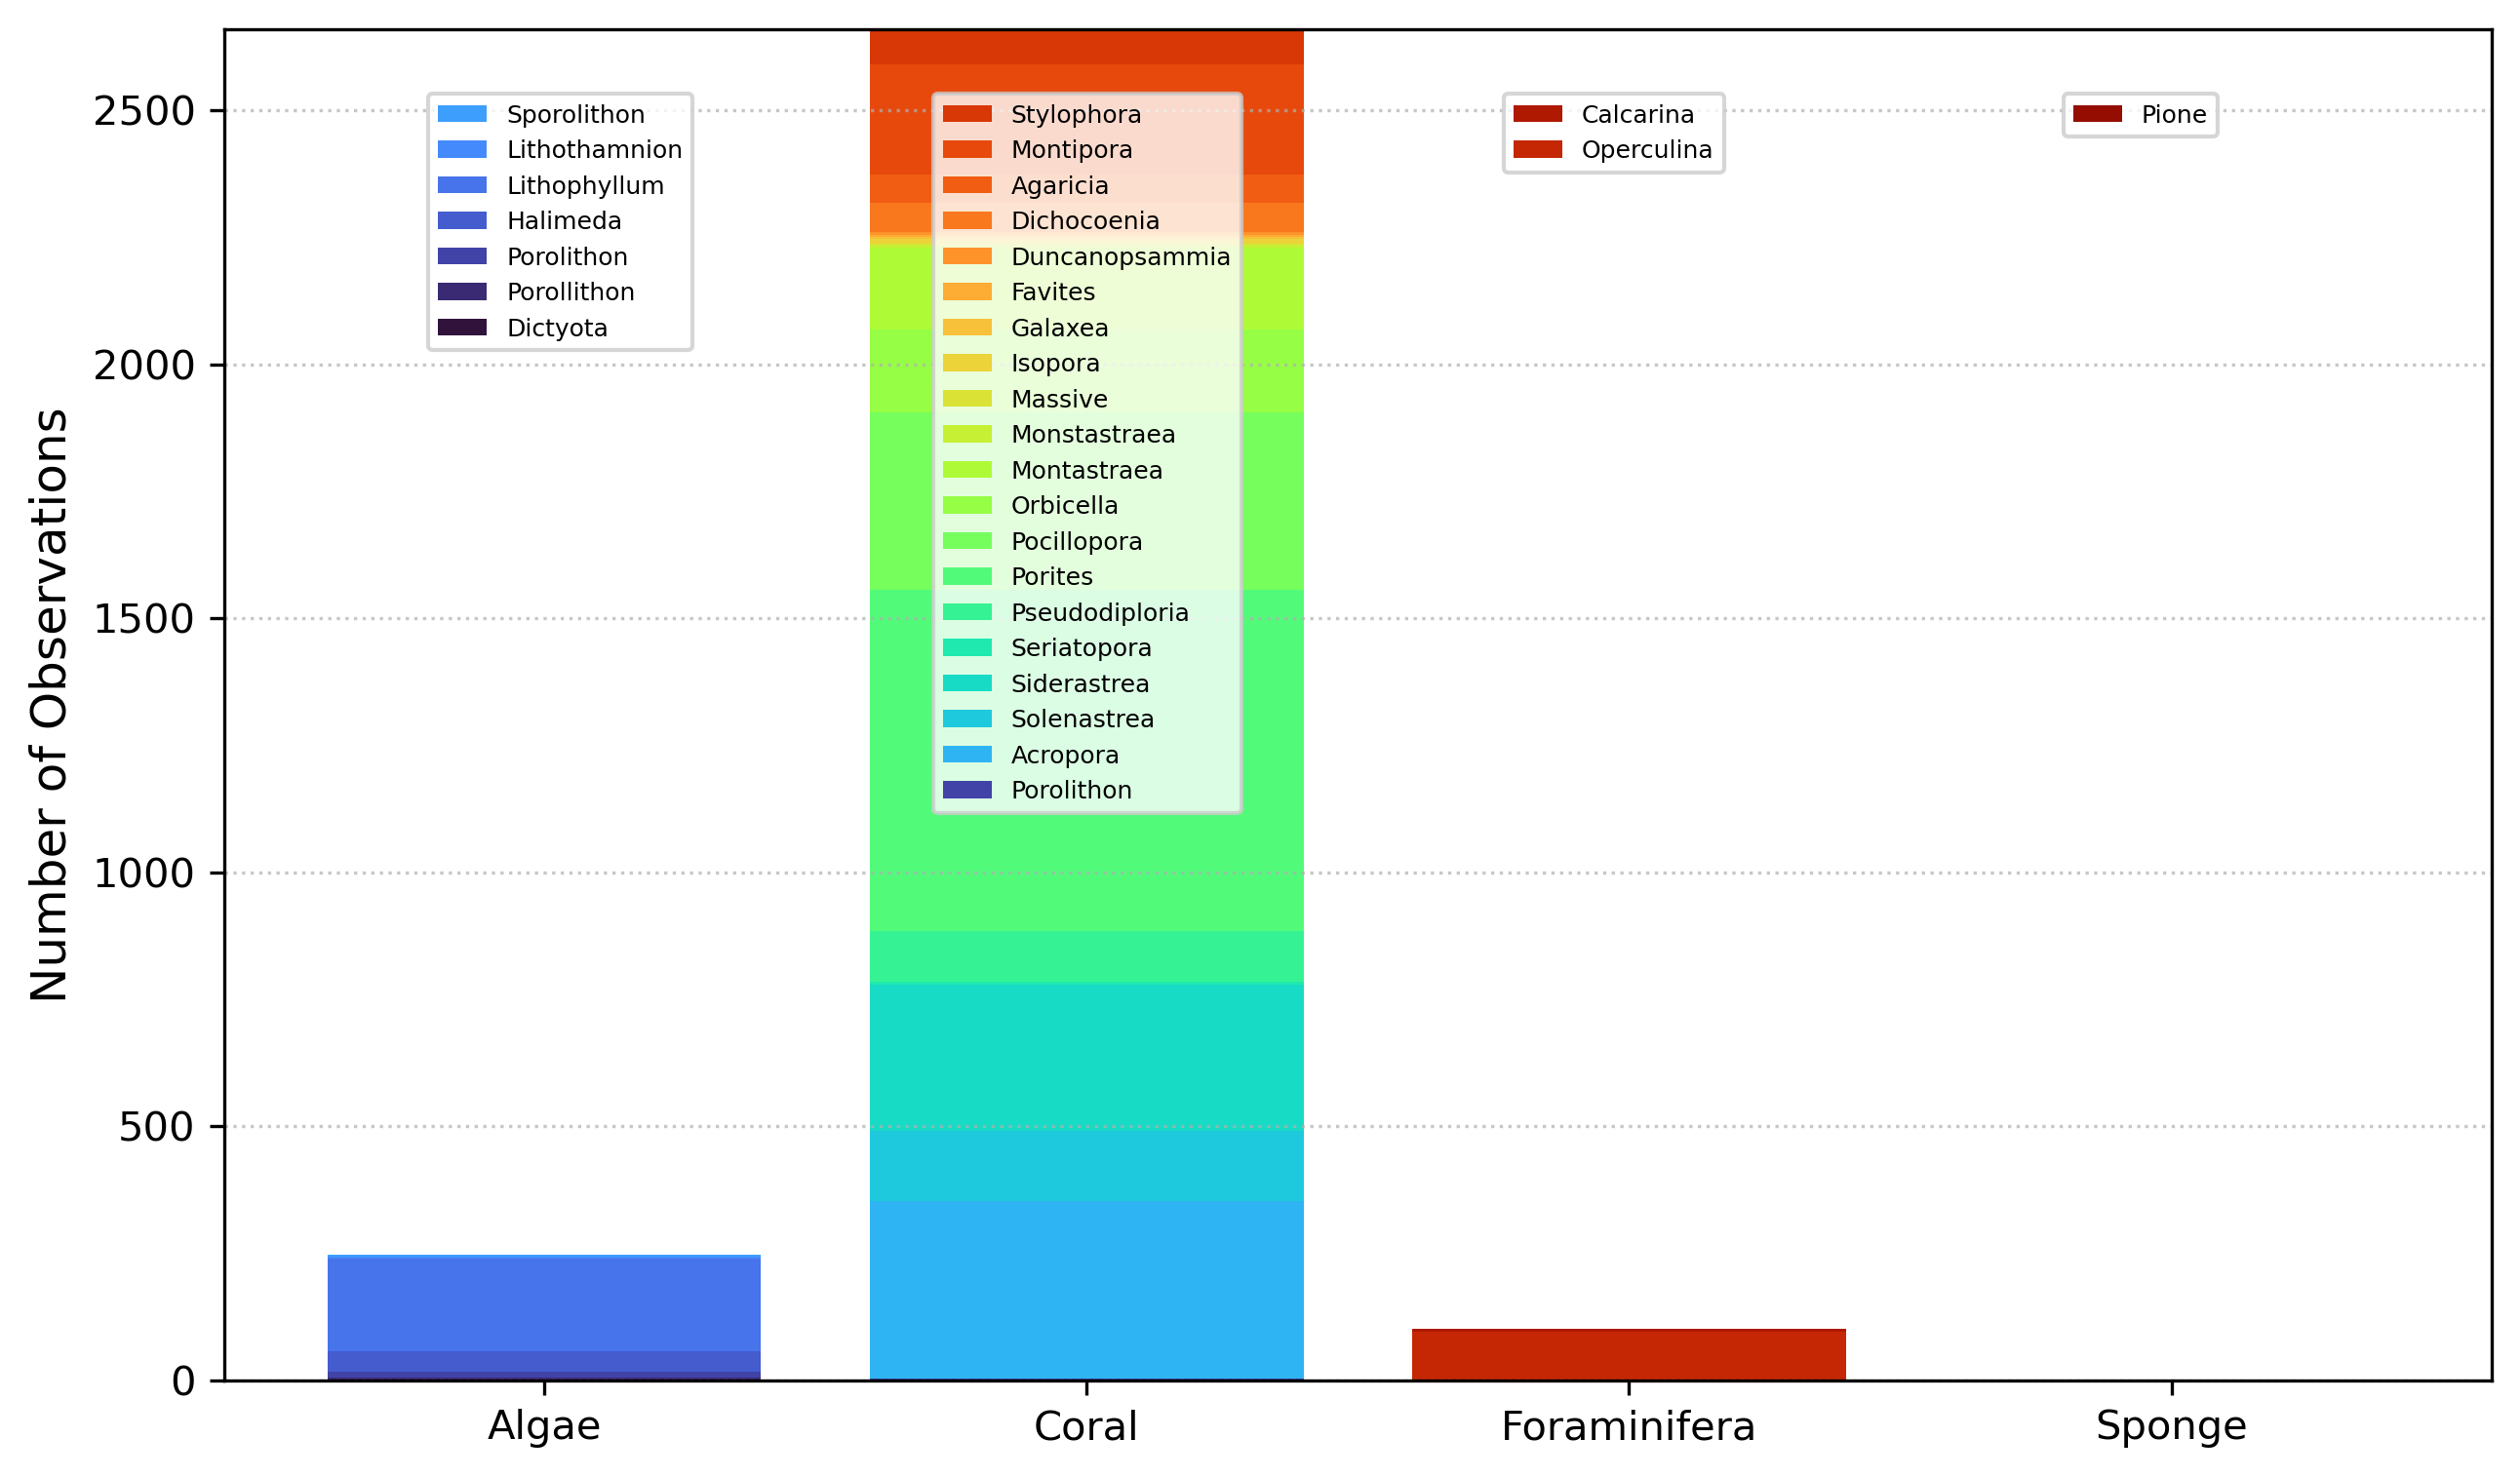

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# aggregate counts of species types within each genus
df['Genus'] = df['Species_types'].str.split(' ', expand=True)[0]
genus_counts = df.groupby(['Taxa', 'Genus']).size().unstack(fill_value=0)
# order by taxon for smooth colours later
first_nonzero = (genus_counts != 0).values.argmax(axis=0)   # find the first nonzero row index for each column
genus_counts = genus_counts.iloc[:, np.argsort(first_nonzero)]  # sort columns based on the first occurrence of nonzero values

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

colormap = plt.get_cmap('turbo')
unique_genera = genus_counts.columns
colors = {genus: colormap(i / len(unique_genera)) for i, genus in enumerate(unique_genera)}

### plot each taxon separately
bottom = np.zeros(len(genus_counts))
legend_handles = {}

for genus in unique_genera:
    values = genus_counts[genus].values
    if np.any(values):  # only plot genera with data
        bars = ax.bar(genus_counts.index, values, bottom=bottom, color=colors[genus], label=genus)
        bottom += values

        for taxon, bar, value in zip(genus_counts.index, bars, values):
            if value > 0:  # only add genera that actually appear
                if taxon not in legend_handles:
                    legend_handles[taxon] = []
                legend_handles[taxon].append((bar, genus))

ax.set_ylabel("Number of Observations", fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle=':', alpha=0.7)


# add separate legends for each taxa (only relevant genera)
for i, (taxon, handles) in enumerate(legend_handles.items()):
    grad_handles = handles[::-1]  # reverse order of handles
    # if taxon != 'Coral':
    #     ax.figure.legend(
    #         [h[0] for h in grad_handles], [h[1] for h in grad_handles],
    #         fontsize=6, loc='upper center', bbox_to_anchor=((0.24 + i * 0.18), 0.85), ncol=1
    #     )
    # else:
    ax.figure.legend(
        [h[0] for h in grad_handles], [h[1] for h in grad_handles],
        fontsize=6, loc='upper center', bbox_to_anchor=((0.24 + i * 0.18), 0.85), ncol=1
    )
        

plt.show()

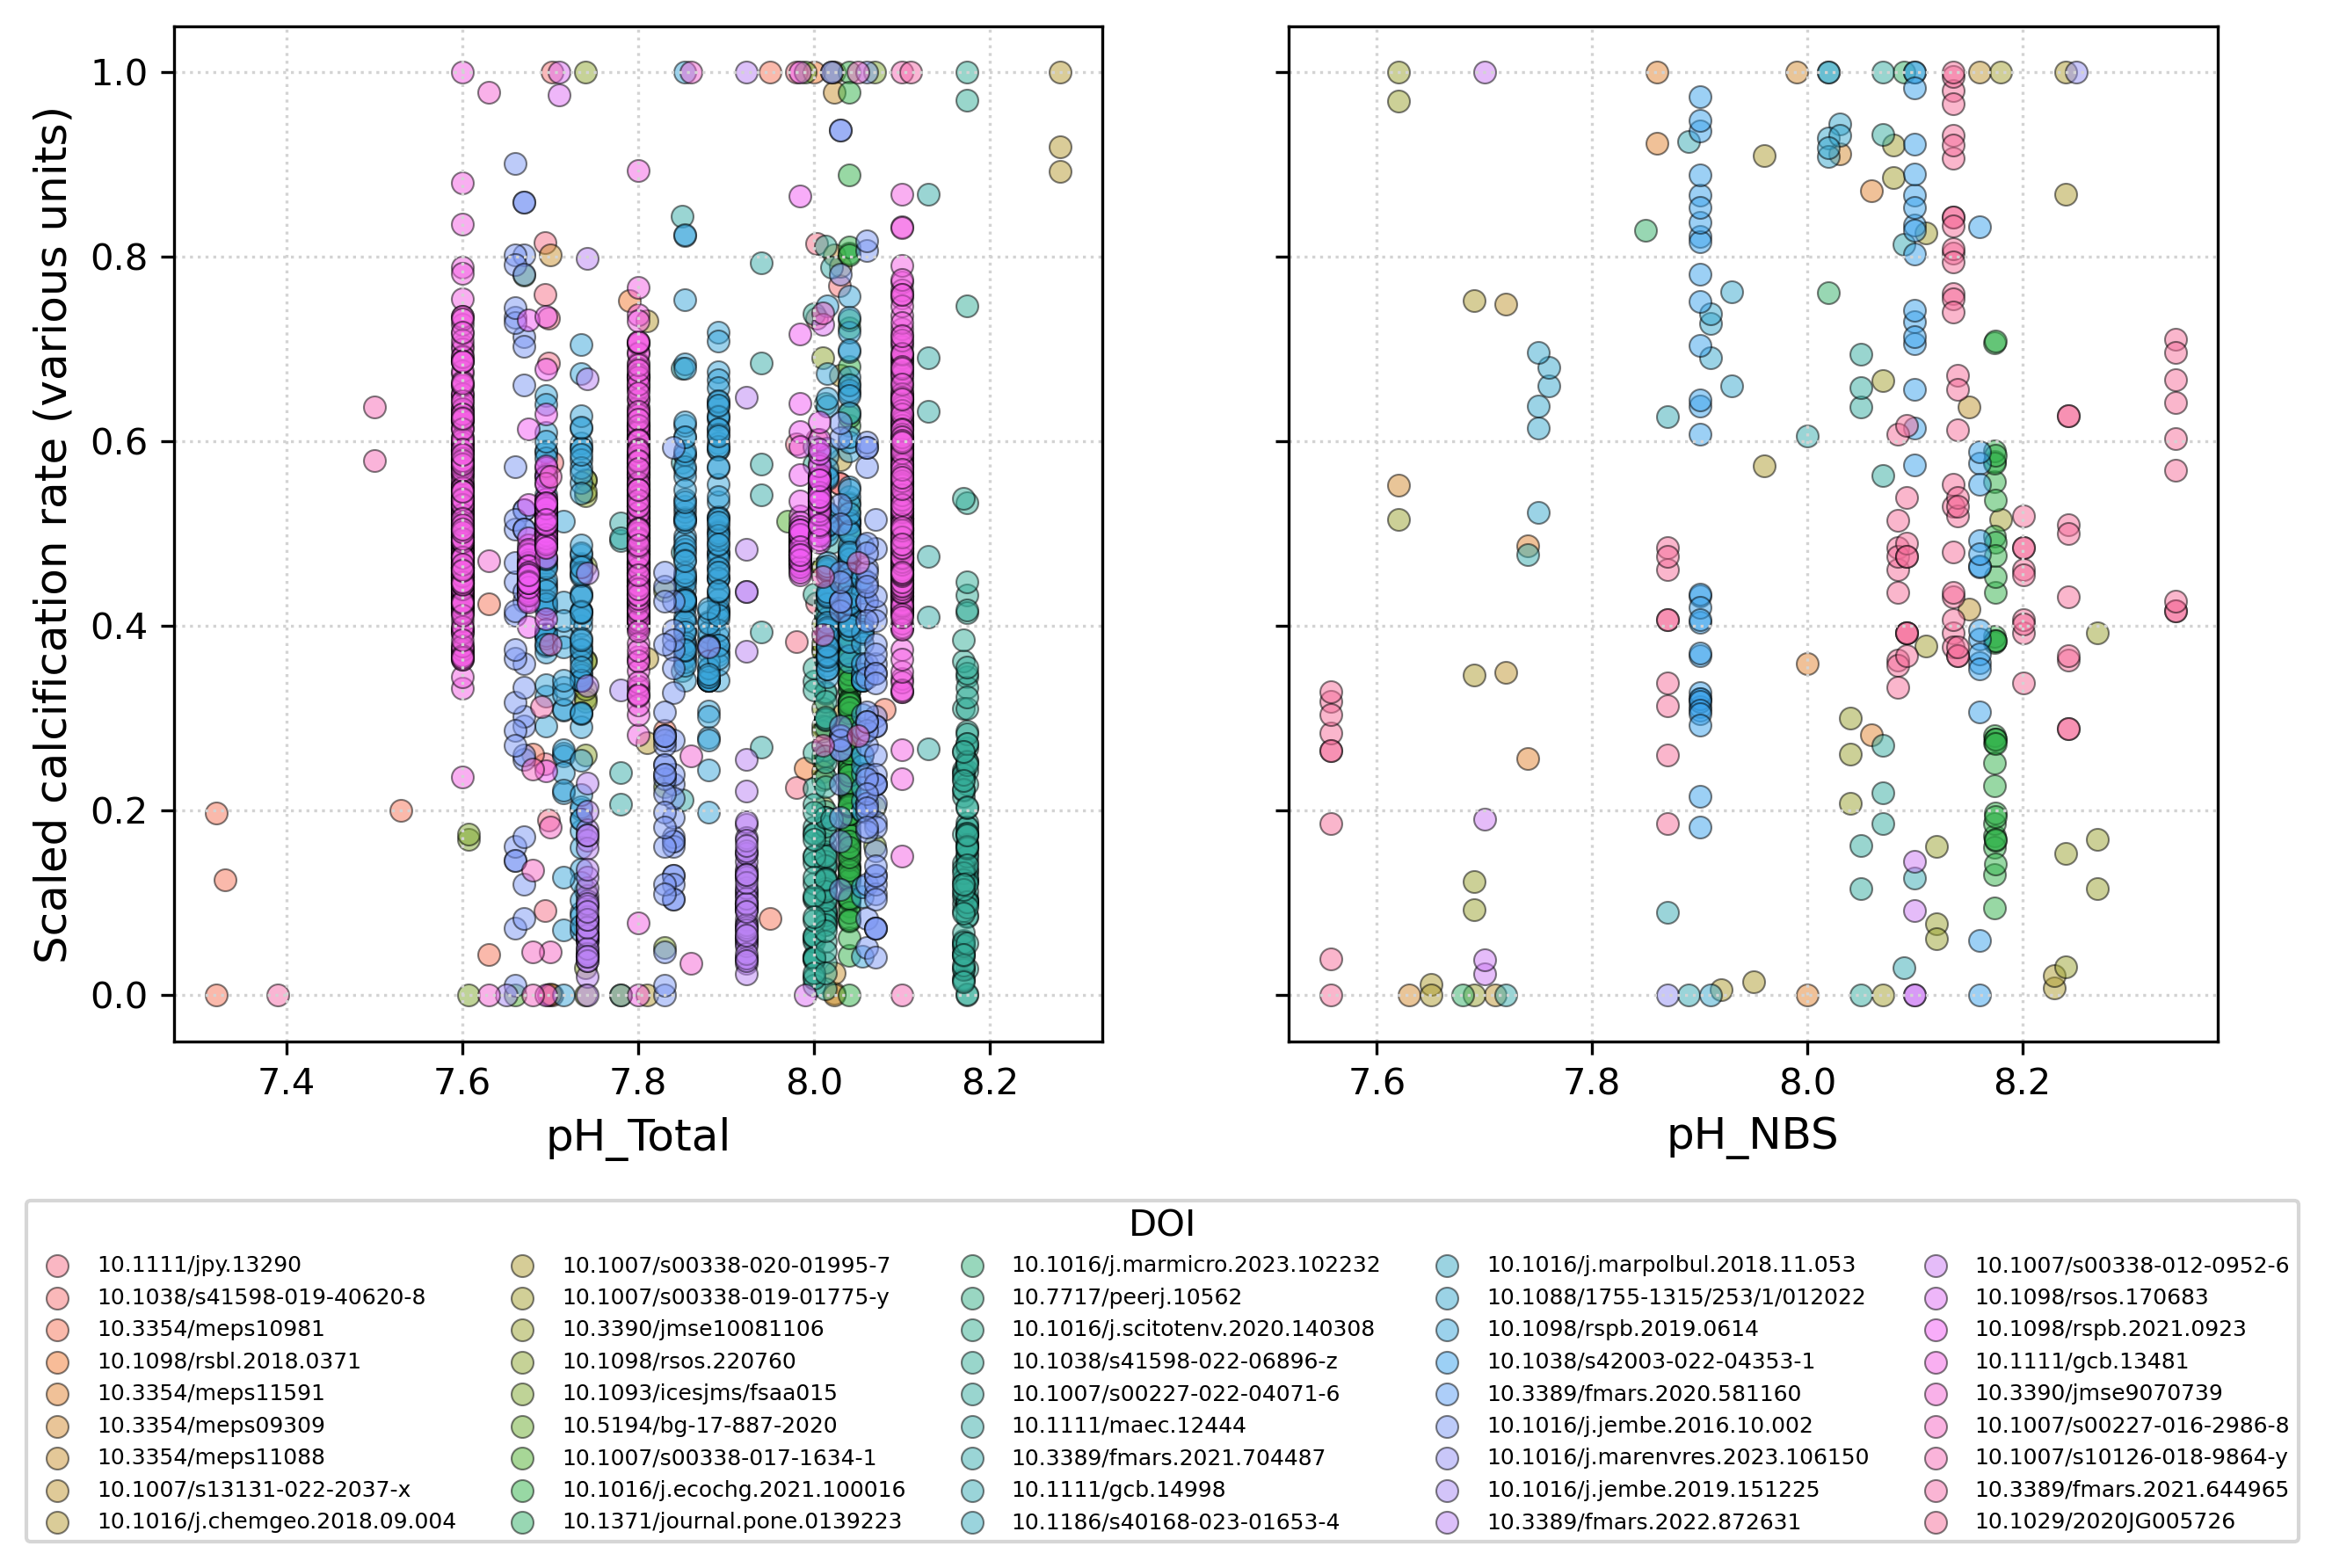

In [383]:
### plot calcification rates against pH (whether Total or NBS)

# df = df[df['DOI'] != '10.1007/s00338-020-01995-7']  # omit DOI = 10.1007/s00338-020-01995-7 (crazy error bars)
# scale calcification rates for quick comparison
df['Calcification_scaled'] = df.groupby("DOI")['Calcification'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Compute range for each study
df['calc_range'] = df.groupby("DOI")['Calcification'].transform(lambda x: x.max() - x.min())

# calculate standard error on mean from standard deviation and sample size
df['se'] = df.apply(lambda row: row['Calcification_sd'] / row['n']**0.5 if pd.notnull(row['Calcification_sd']) and pd.notnull(row['n']) else np.nan, axis=1)
# update se column with any existing calcification se values
df['se'] = df['se'].combine_first(df['Calcification_se'])
# scale standard error using the same factor as calcification rates
df['se_scaled'] = df['se'] / df['calc_range']
# df['se_scaled'] = df.apply(lambda row: row['se'] / row['calc_range']+0.1 if pd.notnull(row['calc_range']) else np.nan, axis=1)
# define marker size based on sample size
df['n'] = pd.to_numeric(df['n'], errors='coerce')  # Convert to numeric # TODO: account for 'M'
df['marker_size'] = df['n'].apply(lambda x: 10 + 60 * (x / df['n'].max()) if pd.notnull(x) else np.nan)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300, sharey=True)
# generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))


for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    # pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']]
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        # ax.errorbar(
        #     doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
        #     fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        # )
        # ax.scatter(
        #     doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
        #     color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        # )
        
        ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'],
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.14), ncol=len(unique_dois)//8, fontsize=6, title="DOI");

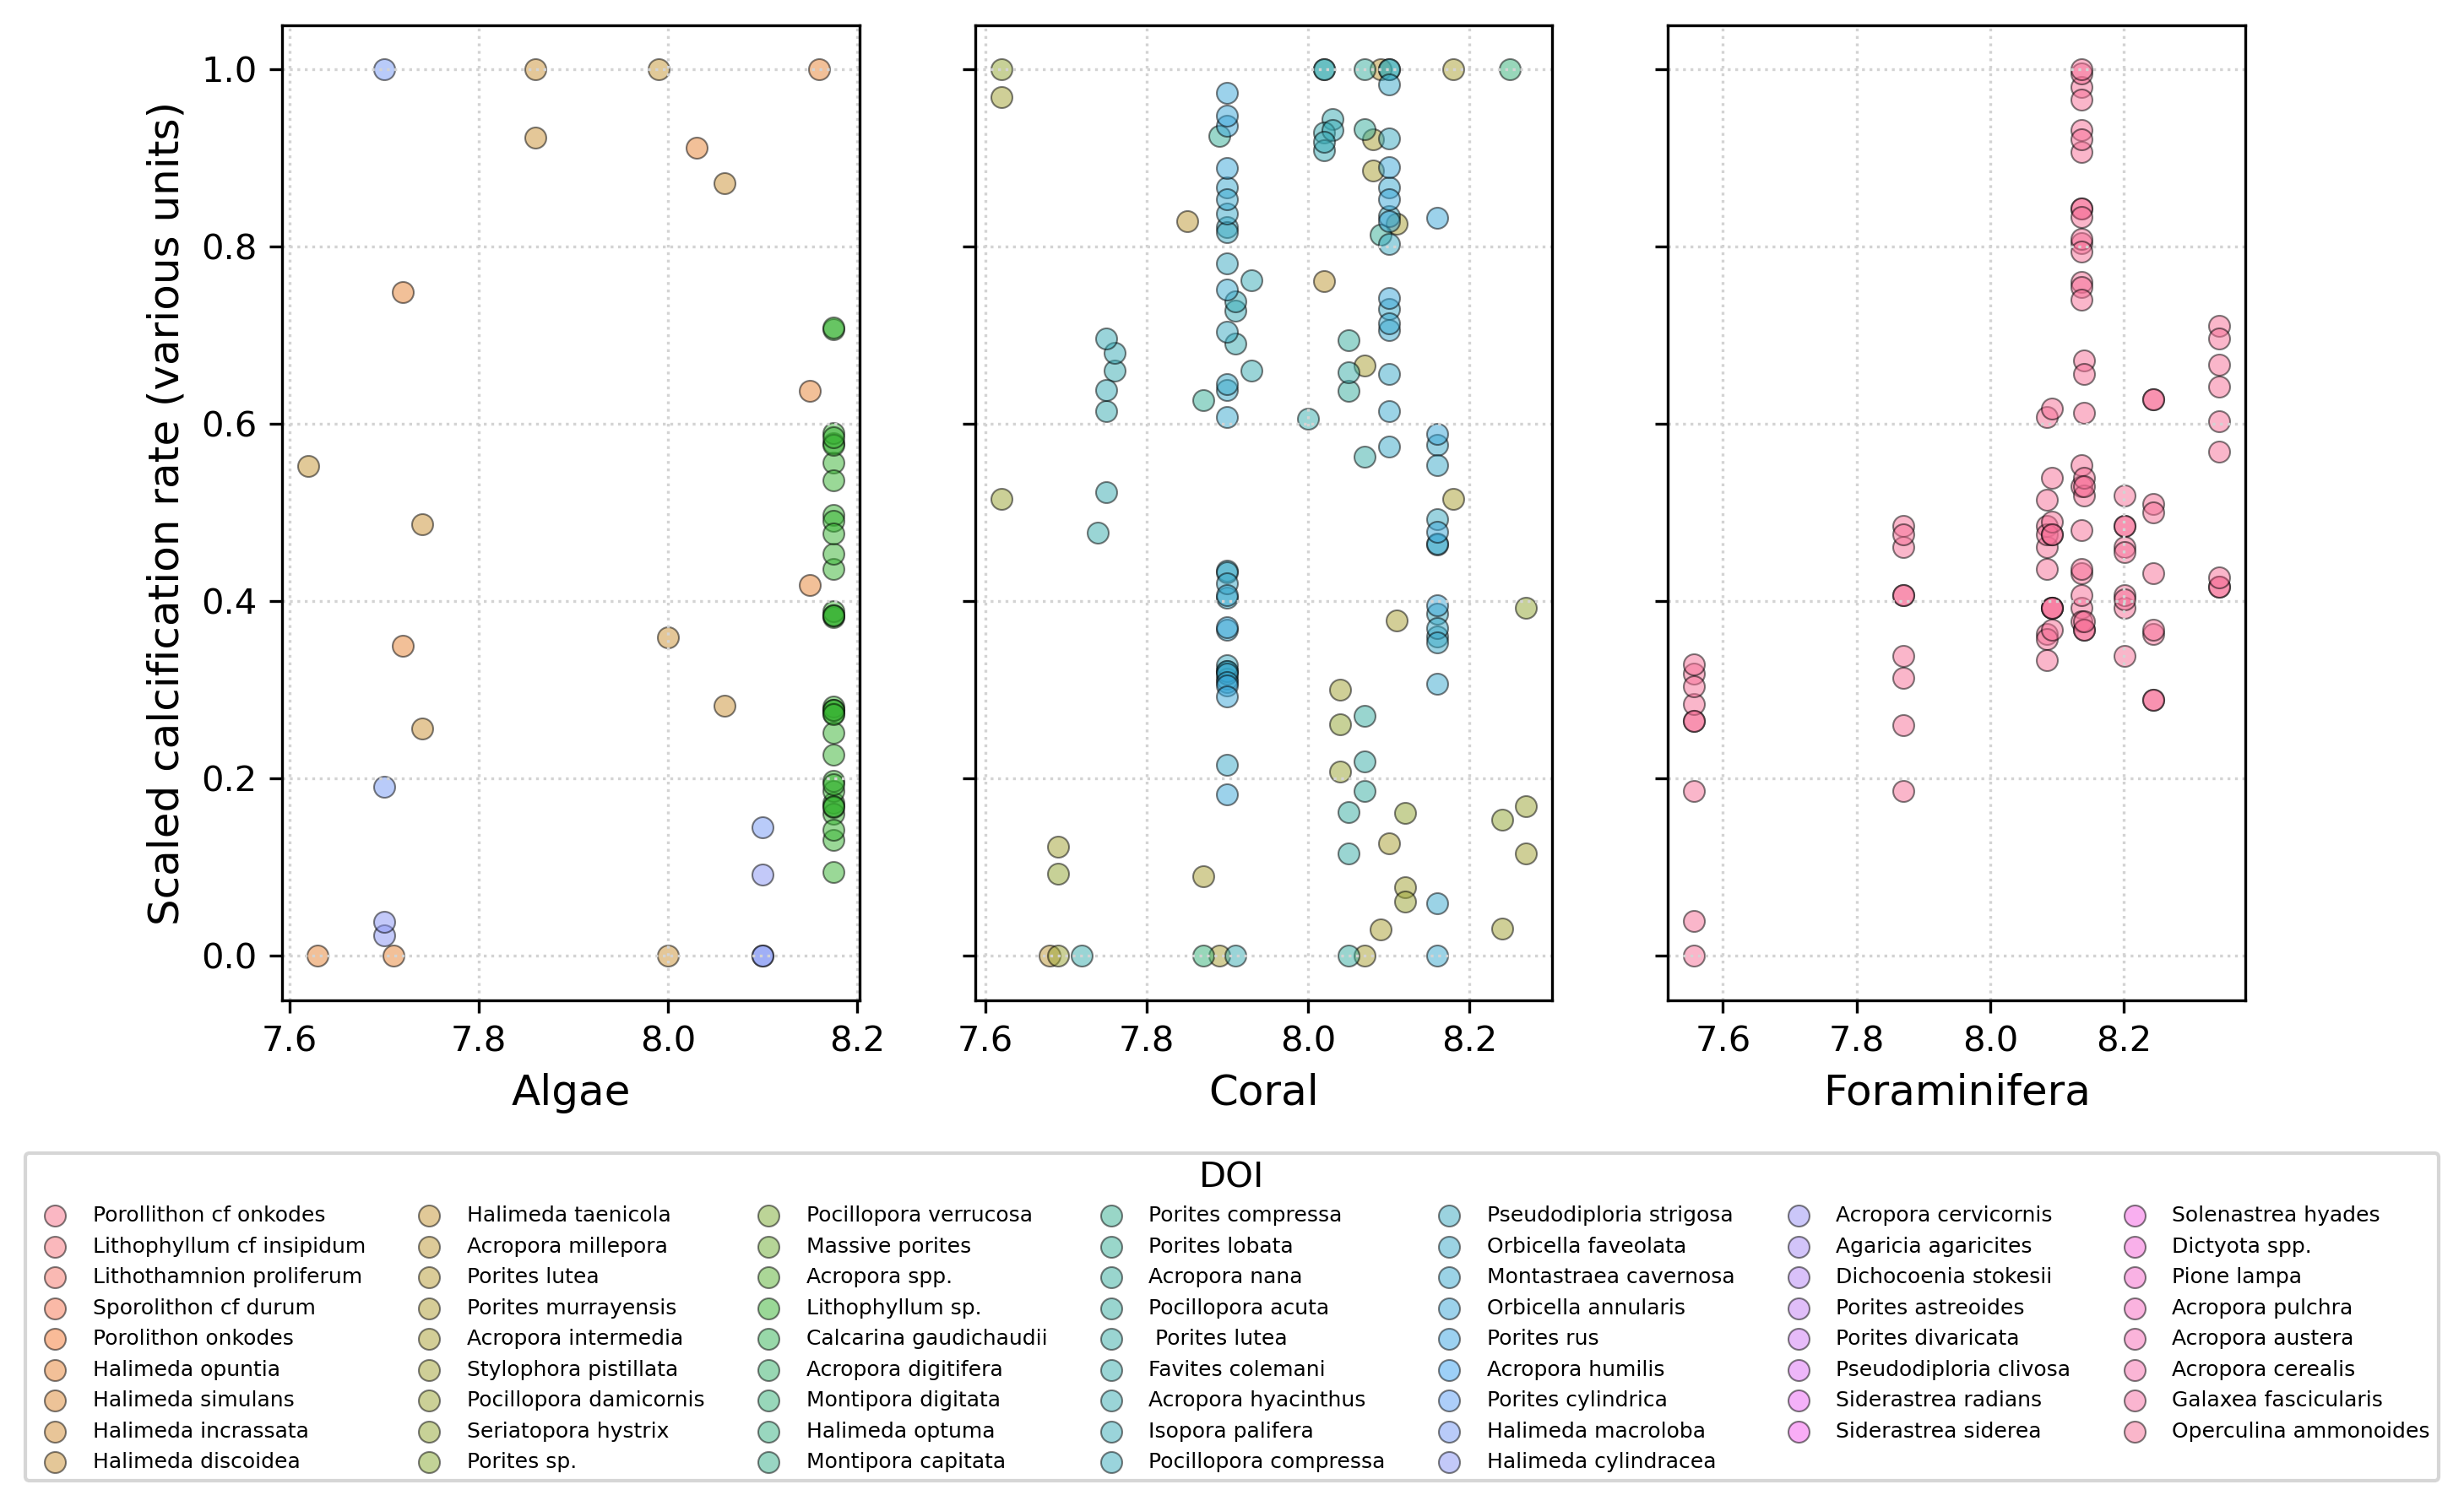

In [341]:
### plot by taxa

ind_var = 'pH_NBS'
unique_species = df['Species_types'].unique()
fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300, sharey=True)
# generate a color palette
palette = sns.color_palette("husl", len(unique_species))
species_color_map = dict(zip(unique_species, palette))


for ax, taxa, title in zip(axes, ['Algae', 'Coral', 'Foraminifera'], ['Algae', 'Coral', 'Foraminifera']):
    taxa_df = df[[ind_var, 'Calcification_scaled', 'se_scaled', 'marker_size', 'Species_types']][df['Taxa'] == taxa]
    # drop nas in se_scaled and marker_size
    # taxa_df = taxa_df.dropna(subset=['se_scaled', 'marker_size'])

    
    for species in unique_species:
        species_df = taxa_df[taxa_df['Species_types'] == species]
        # ax.errorbar(
        #     species_df[species], species_df['Calcification_scaled'], yerr=species_df['se_scaled'], 
        #     fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        # )
        
        # ax.scatter(
        #     species_df[ind_var], species_df['Calcification_scaled'], s=species_df['marker_size'], 
        #     color=species_color_map[species], alpha=0.5, edgecolors='black', linewidth=0.5, label=species
        # )
        
        ax.scatter(
            species_df[ind_var], species_df['Calcification_scaled'],
            color=species_color_map[species], alpha=0.5, edgecolors='black', linewidth=0.5, label=species
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.14), ncol=len(unique_species)//8, fontsize=6, title="DOI");

## Investigating fitting methods

To do:
- Send Ben locations
- Convert Ben's R code into Python
- Fix dropping na by sorting out assignment of se
- ~~Linear response vs other?~~     Staying with linear: supportable
- Additionallly incorporate uncertainty in measurement of independent variable
- Measured vs unmeasured
- Standardise rate units + summarise different types
- Mixed effects
- Hierarchical modelling?

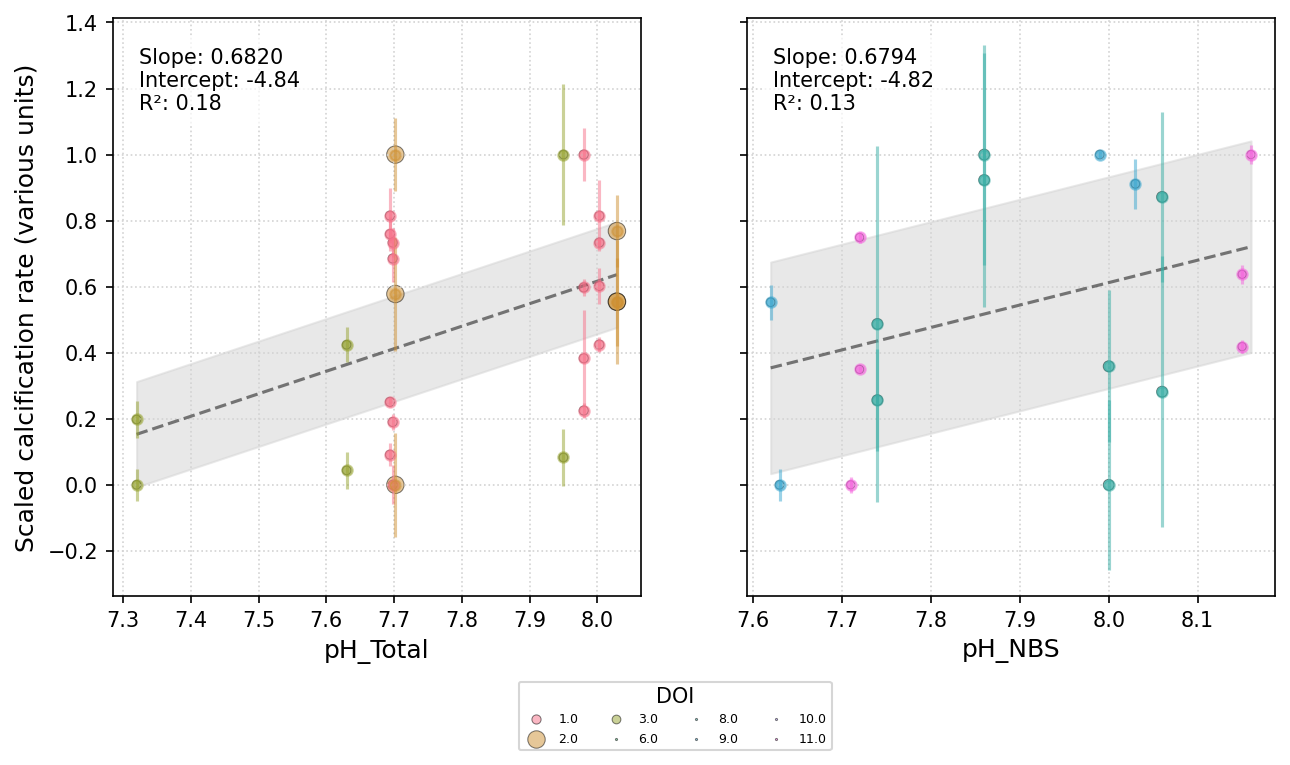

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# generate colour pallete
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

doi_handles, doi_labels = [], []

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()
    
    # least squares regression
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    m, b = np.polyfit(pH_df[pH_col], pH_df['Calcification_scaled'], 1)
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    # plot regression line
    ax.plot(xs, m*xs + b, color='black', alpha=0.5, linestyle='--')
    # ...and shade uncertainty bounds
    ax.fill_between(xs, m*xs + b - 2*pH_df['se_scaled'].mean(), m*xs + b + 2*pH_df['se_scaled'].mean(), 
                    color='lightgray', alpha=0.5)
    # add info to legend    
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    # add datapoints including error bars
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        scatter = ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5
        )
        
        if doi not in doi_labels:   # add only if not already in legend
            doi_handles.append(scatter)
            doi_labels.append(doi)
    
    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()


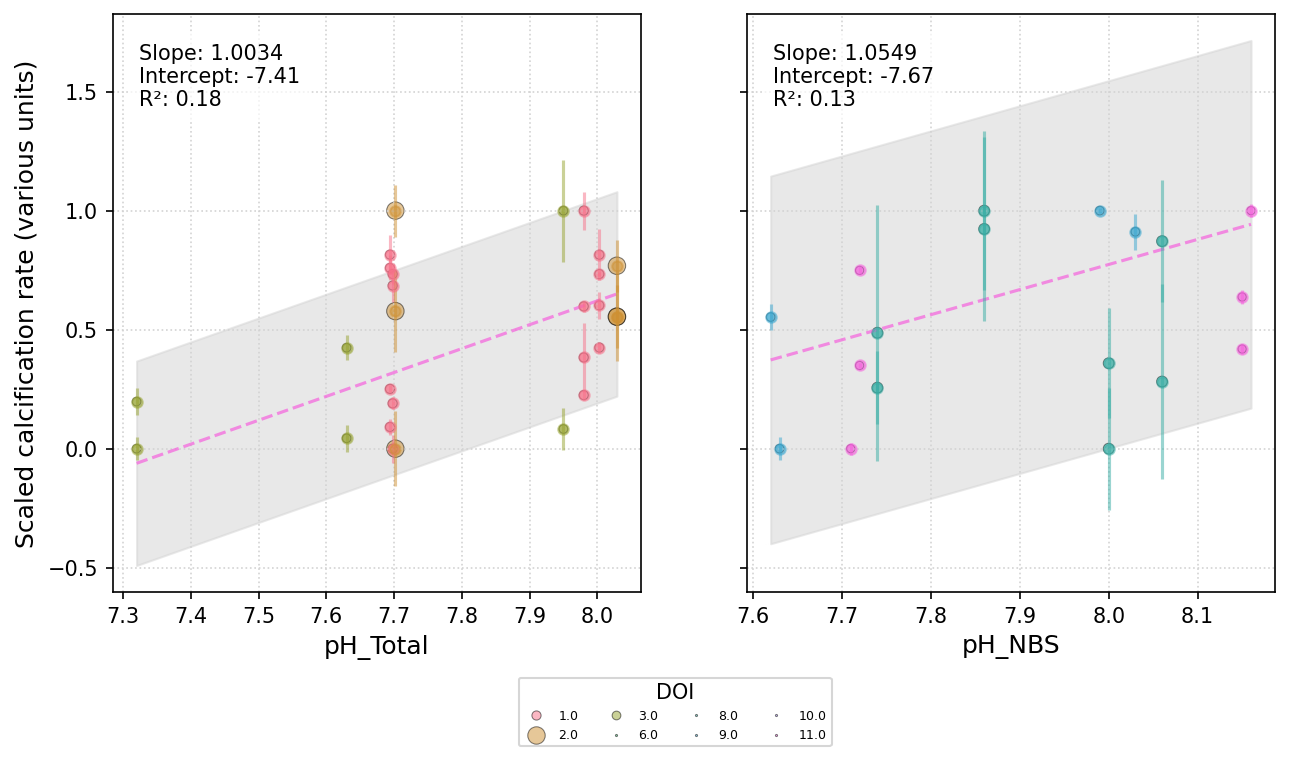

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# Generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()

    # Perform weighted least squares regression (WLS)
    X = sm.add_constant(pH_df[pH_col])  # Add intercept
    y = pH_df['Calcification_scaled']
    weights = 1 / pH_df['se_scaled']**2  # Weight by inverse variance (standard error squared)

    model = sm.WLS(y, X, weights=weights).fit()
    
    # Generate fitted values and confidence intervals
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    Xs = sm.add_constant(xs)  # Add intercept for prediction
    fitted_values = model.predict(Xs)
    
    # get slope and intercept of fitted values
    b, m = model.params
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    
    
    # Add the slope, intercept, and R² to the plot as part of the legend
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    
    # Compute confidence intervals
    predicted_se = np.sqrt(np.diag(model.cov_params()))  # Standard errors of the coefficients
    confidence_interval = 1.96 * predicted_se[1]  # 95% confidence interval for slope (use the second coefficient)
    
    # Plot the fitted regression line and confidence interval
    ax.plot(xs, fitted_values, color=doi_color_map[doi], alpha=0.7, linestyle='--')
    ax.fill_between(xs, fitted_values - confidence_interval, fitted_values + confidence_interval,
                    color='lightgray', alpha=0.5)
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")
    
    if doi not in doi_labels:   # add only if not already in legend
        doi_handles.append(scatter)
        doi_labels.append(doi)

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# Add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()
# N.B. accounting for uncertainty in measured values makes a major difference: compare the slopes

### Work in progress

In [65]:
import statsmodels.api as sm

pH_col = 'pH_Total'
pH_df = df.dropna(subset=[pH_col, 'Calcification_scaled', 'se_scaled'])

X = sm.add_constant(pH_df[pH_col])  # add constant (intercept) term
y = pH_df['Calcification_scaled']   # dependent variable (response)

weights = 1 / 10*pH_df['se_scaled']**2  # calculate the weights (inverse of the squared standard errors). N.B. 10 is a heuristic scaling factor to prevent weight explosion
# adjust X and y for the weights (multiply by sqrt(weights))
X_weighted = X * np.sqrt(np.array(weights))[:, np.newaxis]
y_weighted = y * np.sqrt(np.array(weights))

model = sm.GLS(y_weighted, X_weighted).fit()
print(f"Results for {pH_col}:")
print(model.summary())

Results for pH_Total:
                                  GLS Regression Results                                 
Dep. Variable:     Calcification_scaled   R-squared (uncentered):                   0.779
Model:                              GLS   Adj. R-squared (uncentered):              0.764
Method:                   Least Squares   F-statistic:                              52.87
Date:                  Wed, 12 Feb 2025   Prob (F-statistic):                    1.47e-10
Time:                          01:00:40   Log-Likelihood:                          102.07
No. Observations:                    32   AIC:                                     -200.1
Df Residuals:                        30   BIC:                                     -197.2
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_68091/2698863054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pH_df.loc[:, 'fitted_values'] = model.fittedvalues


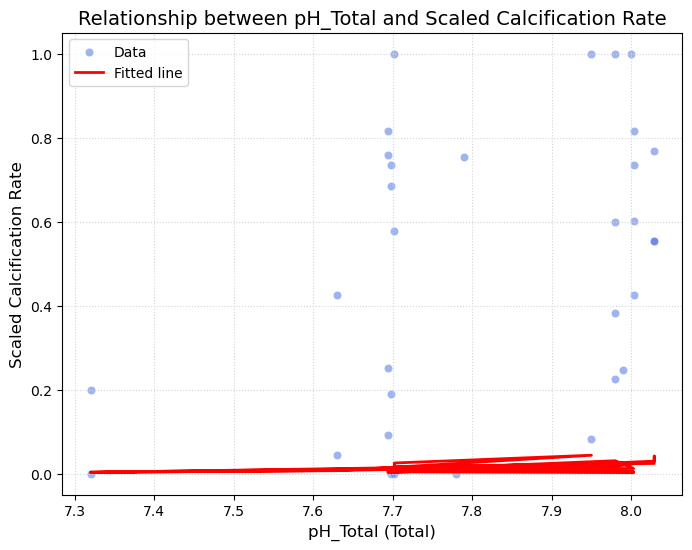

In [66]:
# Get the fitted values
pH_df.loc[:, 'fitted_values'] = model.fittedvalues

# Plotting the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pH_df[pH_col], y=pH_df['Calcification_scaled'], color='royalblue', alpha=0.5, label='Data')

# Plot the regression line (fitted values)
plt.plot(pH_df[pH_col], pH_df['fitted_values'], color='red', label='Fitted line', linewidth=2)

# Calculate the standard errors of the fitted values
predicted_se = np.sqrt(np.diag(model.cov_params()))

# Confidence interval (95%)
confidence_interval = 1.96 * predicted_se

# # Calculate the upper and lower bounds for the fitted values
# upper_bound = pH_df['fitted_values'] + confidence_interval
# lower_bound = pH_df['fitted_values'] - confidence_interval

# # Plot the confidence intervals as a shaded region
# plt.fill_between(pH_df[pH_col], lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

# Add labels and title
plt.xlabel(f'{pH_col} (Total)', fontsize=12)
plt.ylabel('Scaled Calcification Rate', fontsize=12)
plt.title(f'Relationship between {pH_col} and Scaled Calcification Rate', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', color='lightgrey')

# Show the plot
plt.show()